In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import pycolmap
from pathlib import Path

import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from hloc.utils.io import list_h5_names, get_matches

from imc2023.utils.eval import eval

In [3]:
DIR = "../image-matching-challenge-2023"
MODE = "train"

datasets = {
    "heritage": ["cyprus", "dioscuri", "wall"],
    "haiper": ["bike", "chairs", "fountain"],
    "urban": ["kyiv-puppet-theater"],
}

out_dir = Path("../outputs")

In [4]:
runs = os.listdir(out_dir)
runs = [r for r in runs if not r.startswith(".")]
runs = sorted(runs)

fil = ["disk", 'loftr', 'ensemble', 'SG', '1600px']

runs = [r for r in runs if all(f not in r for f in fil)]

len(runs)

17

In [5]:
metrics = {}

for ds in datasets.keys():
    metrics[ds] = {}
    for scene in datasets[ds]:
        metrics[ds][scene] = {}

        img_dir = f"{DIR}/{MODE}/{ds}/{scene}/images"
        images = sorted(os.listdir(img_dir))
        
        metrics[ds][scene]["images"] = images

## Get models for each run

In [6]:
for ds in datasets.keys():
    for scene in datasets[ds]:
        for r in runs:
            model_dir = out_dir / r / ds / scene / "sparse"
            try:
                model = pycolmap.Reconstruction(model_dir)
            except ValueError:
                print(f"No model found for {ds}/{scene} in {r}")

                metrics[ds][scene][r] = {
                    "reg_images": [],
                    "num_reg_images": 0,
                    "model": None,
                }
                continue

            reg_images = [img.name for img in model.images.values()]
            reg_images = sorted(reg_images)
            metrics[ds][scene][r] = {
                "reg_images": reg_images,
                "num_reg_images": len(reg_images),
                "model": model,
            }

No model found for heritage/cyprus in DISK+LG
No model found for heritage/cyprus in sift+NN
No model found for heritage/dioscuri in DISK+SP+LG-rot-pixsfm-sci
No model found for heritage/dioscuri in DISK+SP+LG-rot-sci
No model found for haiper/chairs in sift+NN
No model found for haiper/chairs in sift+NN-old
No model found for urban/kyiv-puppet-theater in sift+NN
No model found for urban/kyiv-puppet-theater in sift+NN-old


## Get eval for each run

In [7]:
create_score = {r: True for r in runs}

for ds in datasets.keys():
    for scene in datasets[ds]:
        pbar = tqdm(runs, desc=f"{ds}/{scene}")
        for r in pbar:
            submission = Path(f"{out_dir}/{r}/submission.csv")
            scores = Path(f"{out_dir}/{r}/scores.json")

            if scores.exists() and not create_score[r]:
                with open(scores, "r") as f:
                    metrics[ds][scene][r]["scores"] = json.load(f)
                continue

            if submission.exists():
                try:
                    metrics[ds][scene][r]["scores"] = eval(
                        submission, DIR, verbose=False, return_dict=True,
                    )
                    create_score[r] = False
                except:
                    metrics[ds][scene][r]["scores"] = None
            else:
                metrics[ds][scene][r]["scores"] = None

            if metrics[ds][scene][r]["scores"] is not None:
                # write scores to file
                with open(f"{out_dir}/{r}/scores.json", "w") as f:
                    json.dump(metrics[ds][scene][r]["scores"], f, indent=4)

                    


urban/kyiv-puppet-theater: 100%|██████████| 17/17 [00:00<00:00, 11913.65it/s]


## Get runtimes

In [8]:
for ds in datasets:
    for scene in datasets[ds]:
        for r in runs:
            timings_path = f"{out_dir}/{r}/{ds}/{scene}/timings.json"

            timings = None
            if os.path.exists(timings_path):
                with open(timings_path, "r") as f:
                    timings = json.load(f)
                
            metrics[ds][scene][r]["timings"] = timings

## Create dataframe

In [9]:
df = []

pipline_steps = ['preprocessing', 'pairs-extraction', 'feature-extraction', 'feature-matching', 'create-ensemble', 'rotate-keypoints', 'sfm', 'localize-unreg']

for r in runs:
    row = ()
    cols = ()
    row += (r,)
    cols += ("run",)

    if metrics["heritage"]["cyprus"][r]["scores"] is not None:
        row += (metrics["heritage"]["cyprus"][r]["scores"]["mAA"],)
        cols += ("mAA",)


        for ds in datasets:
            scene = datasets[ds][0]
            row += (metrics[ds][scene][r]["scores"][ds]["mAA"],)
            cols += (f"{ds}_mAA",)
            for scene in datasets[ds]:
                row += (
                    metrics[ds][scene][r]["scores"][ds][scene]["mAA_t"],
                    metrics[ds][scene][r]["scores"][ds][scene]["mAA_q"],
                    metrics[ds][scene][r]["scores"][ds][scene]["mAA"],
                )
                cols += (
                    f"{ds}_{scene}_mAA_t",
                    f"{ds}_{scene}_mAA_q",
                    f"{ds}_{scene}_mAA",
                )
    else:
        for ds in datasets:
            row += (0,)
            cols += (f"{ds}_mAA",)
            for scene in datasets[ds]:
                row += (0, 0, 0,)
                cols += (
                    f"{ds}_{scene}_mAA_t",
                    f"{ds}_{scene}_mAA_q",
                    f"{ds}_{scene}_mAA",
                )

    if metrics["heritage"]["cyprus"][r]["model"] is not None:
        for ds in datasets:
            for scene in datasets[ds]:
                row += (metrics[ds][scene][r]["num_reg_images"],)
                cols += (f"{ds}_{scene}_num_reg_images",)
    else:
        for ds in datasets:
            for scene in datasets[ds]:
                row += (0,)
                cols += (f"{ds}_{scene}_num_reg_images",)

    for ds in datasets:
        for scene in datasets[ds]:
            if metrics[ds][scene][r]["timings"] is not None:
                for step in pipline_steps:
                    row += (metrics[ds][scene][r]["timings"][step],)
                    cols += (f"{ds}_{scene}_{step}_time",)
            else:
                for step in pipline_steps:
                    row += (0,)
                    cols += (f"{ds}_{scene}_{step}_time",)
                
    df.append(row)

df = pd.DataFrame(df, columns=cols)

df.sort_values(by=["run"], inplace=True, ascending=True)
df.set_index("run", inplace=True, drop=False)

df

run       mAA  \
run                                                                
DISK+LG                                        DISK+LG  0.610733   
DISK+LG+sift+NN-rot                DISK+LG+sift+NN-rot  0.720306   
DISK+LG+sift+NN-rot-pixsfm  DISK+LG+sift+NN-rot-pixsfm  0.700360   
DISK+LG-rot                                DISK+LG-rot  0.746279   
DISK+LG-rot-pixsfm                  DISK+LG-rot-pixsfm  0.657996   
DISK+SP+LG-rot                          DISK+SP+LG-rot  0.825781   
DISK+SP+LG-rot-pixsfm            DISK+SP+LG-rot-pixsfm  0.803276   
DISK+SP+LG-rot-pixsfm-sci    DISK+SP+LG-rot-pixsfm-sci  0.776227   
DISK+SP+LG-rot-sci                  DISK+SP+LG-rot-sci  0.749124   
SP+LG+exhaustive-rot              SP+LG+exhaustive-rot  0.735356   
SP+LG+sift+NN-rot                    SP+LG+sift+NN-rot  0.809958   
SP+LG+sift+NN-rot-pixsfm      SP+LG+sift+NN-rot-pixsfm  0.783899   
SP+LG-rot                                    SP+LG-rot  0.783511   
SP+LG-rot-pixsfm                      SP+LG-rot-pixsfm  0.764002   
SP+LG-rot-sci                            SP+LG-rot-sci  0.723297   
sift+NN                                        sift+NN  0.278251   
sift+NN-old                                sift+NN-old  0.355741   

                            heritage_mAA  heritage_cyprus_mAA_t  \
run                                                               
DISK+LG                         0.391017               0.003218   
DISK+LG+sift+NN-rot             0.687547               0.769195   
DISK+LG+sift+NN-rot-pixsfm      0.515641               0.196092   
DISK+LG-rot                     0.625685               0.765057   
DISK+LG-rot-pixsfm              0.438581               0.191034   
DISK+SP+LG-rot                  0.683876               0.806897   
DISK+SP+LG-rot-pixsfm           0.710020               0.806437   
DISK+SP+LG-rot-pixsfm-sci       0.519914               0.881839   
DISK+SP+LG-rot-sci              0.496314               0.824368   
SP+LG+exhaustive-rot            0.670298               0.646896   
SP+LG+sift+NN-rot               0.699488               0.900460   
SP+LG+sift+NN-rot-pixsfm        0.675141               0.658621   
SP+LG-rot                       0.633125               0.806667   
SP+LG-rot-pixsfm                0.620031               0.625517   
SP+LG-rot-sci                   0.392492               0.662988   
sift+NN                         0.357424               0.003218   
sift+NN-old                     0.583863               0.520460   

                            heritage_cyprus_mAA_q  heritage_cyprus_mAA  \
run                                                                      
DISK+LG                                  0.000460             0.000000   
DISK+LG+sift+NN-rot                      0.753103             0.745287   
DISK+LG+sift+NN-rot-pixsfm               0.178851             0.168506   
DISK+LG-rot                              0.747126             0.744368   
DISK+LG-rot-pixsfm                       0.177931             0.162759   
DISK+SP+LG-rot                           0.830345             0.786207   
DISK+SP+LG-rot-pixsfm                    0.826667             0.783218   
DISK+SP+LG-rot-pixsfm-sci                0.862069             0.858621   
DISK+SP+LG-rot-sci                       0.803218             0.797011   
SP+LG+exhaustive-rot                     0.618621             0.605747   
SP+LG+sift+NN-rot                        0.920690             0.888965   
SP+LG+sift+NN-rot-pixsfm                 0.654253             0.619540   
SP+LG-rot                                0.798851             0.786897   
SP+LG-rot-pixsfm                         0.613333             0.596092   
SP+LG-rot-sci                            0.623448             0.616552   
sift+NN                                  0.000460             0.000000   
sift+NN-old                              0.520460             0.502759   

                            heritage_dioscuri_mAA_t  heritage_dioscuri_mAA_q 

In [10]:
df.loc["DISK+LG", "heritage_mAA"]

0.39101704955101013

# Get best runs

In [11]:
df[["mAA"]].sort_values(by=["mAA"], ascending=False)

mAA
run                                 
DISK+SP+LG-rot              0.825781
SP+LG+sift+NN-rot           0.809958
DISK+SP+LG-rot-pixsfm       0.803276
SP+LG+sift+NN-rot-pixsfm    0.783899
SP+LG-rot                   0.783511
DISK+SP+LG-rot-pixsfm-sci   0.776227
SP+LG-rot-pixsfm            0.764002
DISK+SP+LG-rot-sci          0.749124
DISK+LG-rot                 0.746279
SP+LG+exhaustive-rot        0.735356
SP+LG-rot-sci               0.723297
DISK+LG+sift+NN-rot         0.720306
DISK+LG+sift+NN-rot-pixsfm  0.700360
DISK+LG-rot-pixsfm          0.657996
DISK+LG                     0.610733
sift+NN-old                 0.355741
sift+NN                     0.278251

In [12]:
# get the best run for each dataset and scene from the dataframe

max_str = max(len(ds) + len(scene) for ds in datasets.keys() for scene in datasets[ds]) + 1

for ds in datasets:
    for scene in datasets[ds]:
        name = df.loc[:, f"{ds}_{scene}_mAA"].idxmax()
        # name = df.iloc[idx].run
        mAA = df.loc[name, f"{ds}_{scene}_mAA"]
        print(f"{f'{ds}/{scene}':{max_str}}: {mAA:.4f} ({name})")

    print()



heritage/cyprus          : 0.8890 (SP+LG+sift+NN-rot)
heritage/dioscuri        : 0.7837 (SP+LG+sift+NN-rot)
heritage/wall            : 0.7532 (DISK+LG+sift+NN-rot-pixsfm)

haiper/bike              : 0.9286 (DISK+LG)
haiper/chairs            : 0.9817 (DISK+SP+LG-rot-sci)
haiper/fountain          : 1.0000 (DISK+SP+LG-rot-pixsfm)

urban/kyiv-puppet-theater: 0.8532 (SP+LG-rot-sci)



## Plot scores

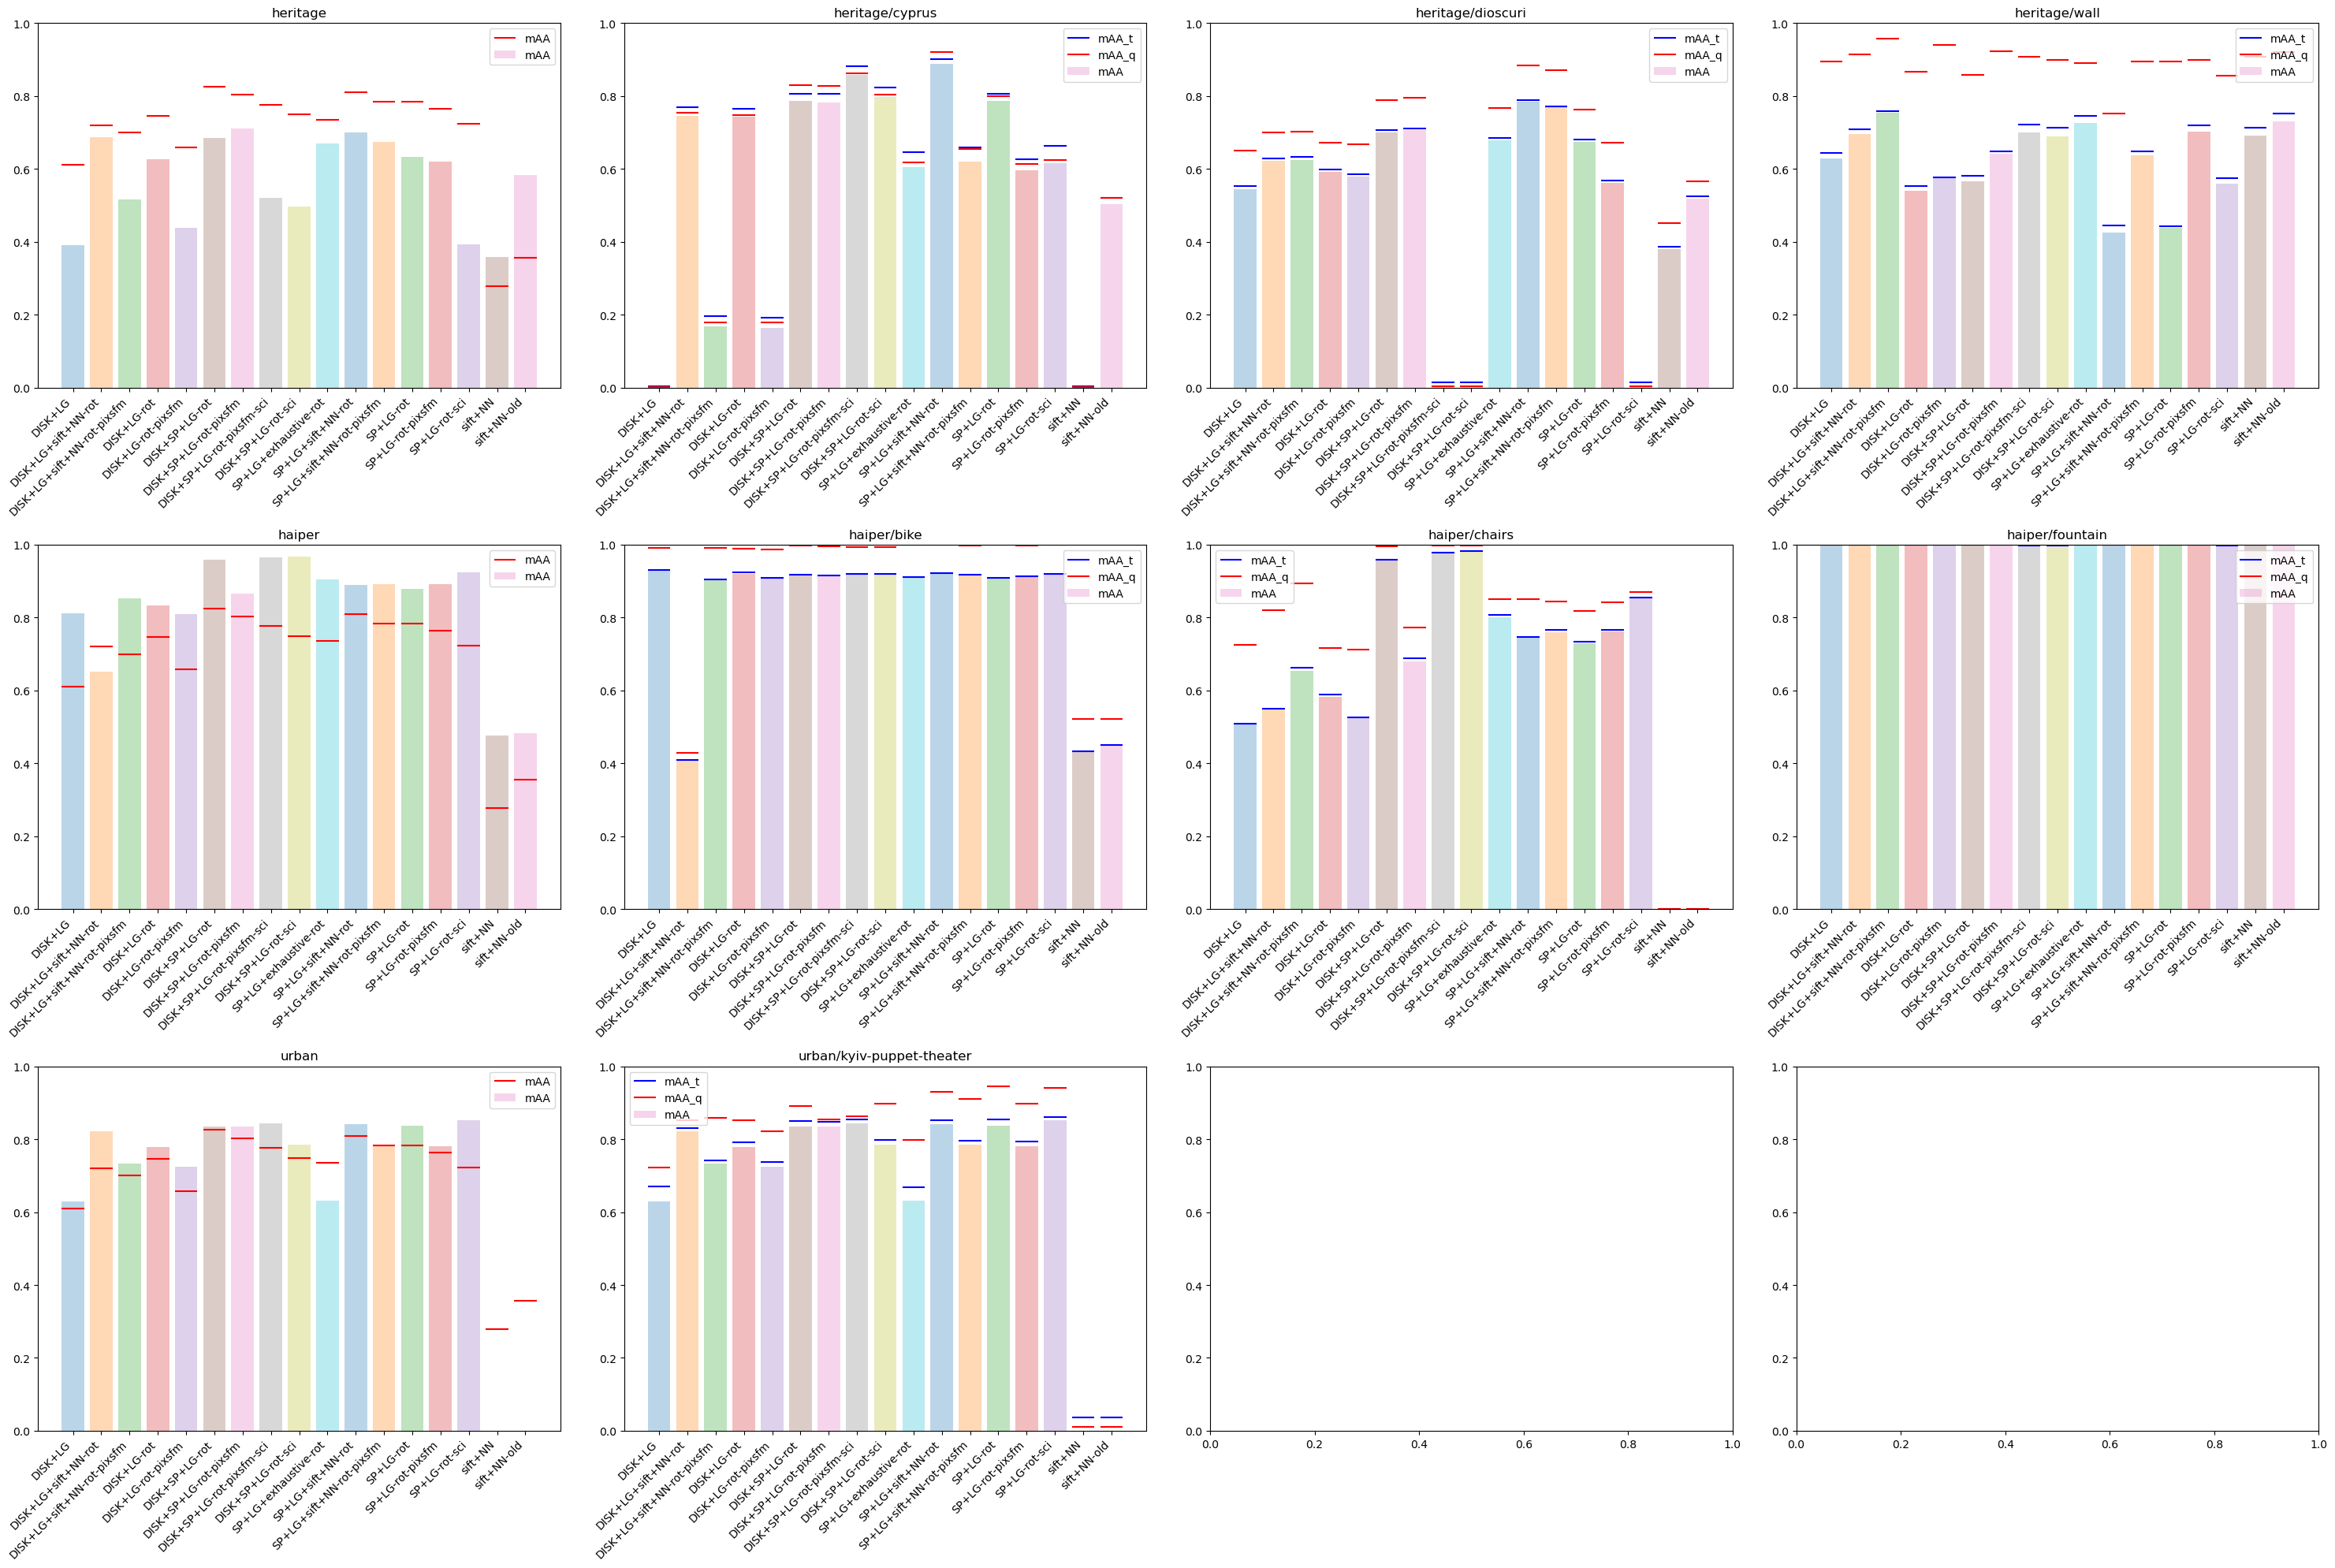

In [27]:
fig, ax = plt.subplots(len(datasets), len(datasets["heritage"])+1, figsize=(30, 20))

for i, ds in enumerate(datasets.keys()):
    for r in df.index:
        name = df.loc[r, "run"]
        ds_mAA = df.loc[r, f"{ds}_mAA"]
        mAA = df.loc[r, "mAA"]
        ax[i, 0].bar(
            name,
            ds_mAA,
            alpha=0.3,
            label="mAA" if r == df.index[-1] else "",
        )

        ax[i, 0].hlines(
            mAA,
            df.index.tolist().index(r) - 0.4,
            df.index.tolist().index(r) + 0.4,
            color="red",
            label="mAA" if r == df.index[-1] else "",
        )

        # rotate the xticklabels
        for tick in ax[i, 0].get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha("right")

    ax[i, 0].set_ylim([0, 1])
    ax[i, 0].set_title(ds)
    ax[i, 0].legend()


    for j, scene in enumerate(datasets[ds]):
        for r in df.index:
            name = df.loc[r, "run"]
            mAA = df.loc[r, f"{ds}_{scene}_mAA"]
            mAA_t = df.loc[r, f"{ds}_{scene}_mAA_t"]
            mAA_q = df.loc[r, f"{ds}_{scene}_mAA_q"]

            ax[i, j+1].bar(
                name,
                mAA,
                alpha=0.3,
                label="mAA" if r == df.index[-1] else "",
            )

            ax[i, j+1].hlines(
                mAA_t,
                df.index.tolist().index(r) - 0.4,
                df.index.tolist().index(r) + 0.4,
                color="b",
                label="mAA_t" if r == df.index[-1] else "",
            )

            ax[i, j+1].hlines(
                mAA_q,
                df.index.tolist().index(r) - 0.4,
                df.index.tolist().index(r) + 0.4,
                color="r",
                label="mAA_q" if r == df.index[-1] else "",
            )

            # rotate x-axis labels and align them to the right
            for tick in ax[i, j+1].get_xticklabels():
                tick.set_rotation(45)
                tick.set_ha("right")

        ax[i, j+1].set_ylim(0, 1)
        ax[i, j+1].set_title(f"{ds}/{scene}")
        ax[i, j+1].legend()
            
plt.tight_layout()
plt.show()

## Plot num registered images

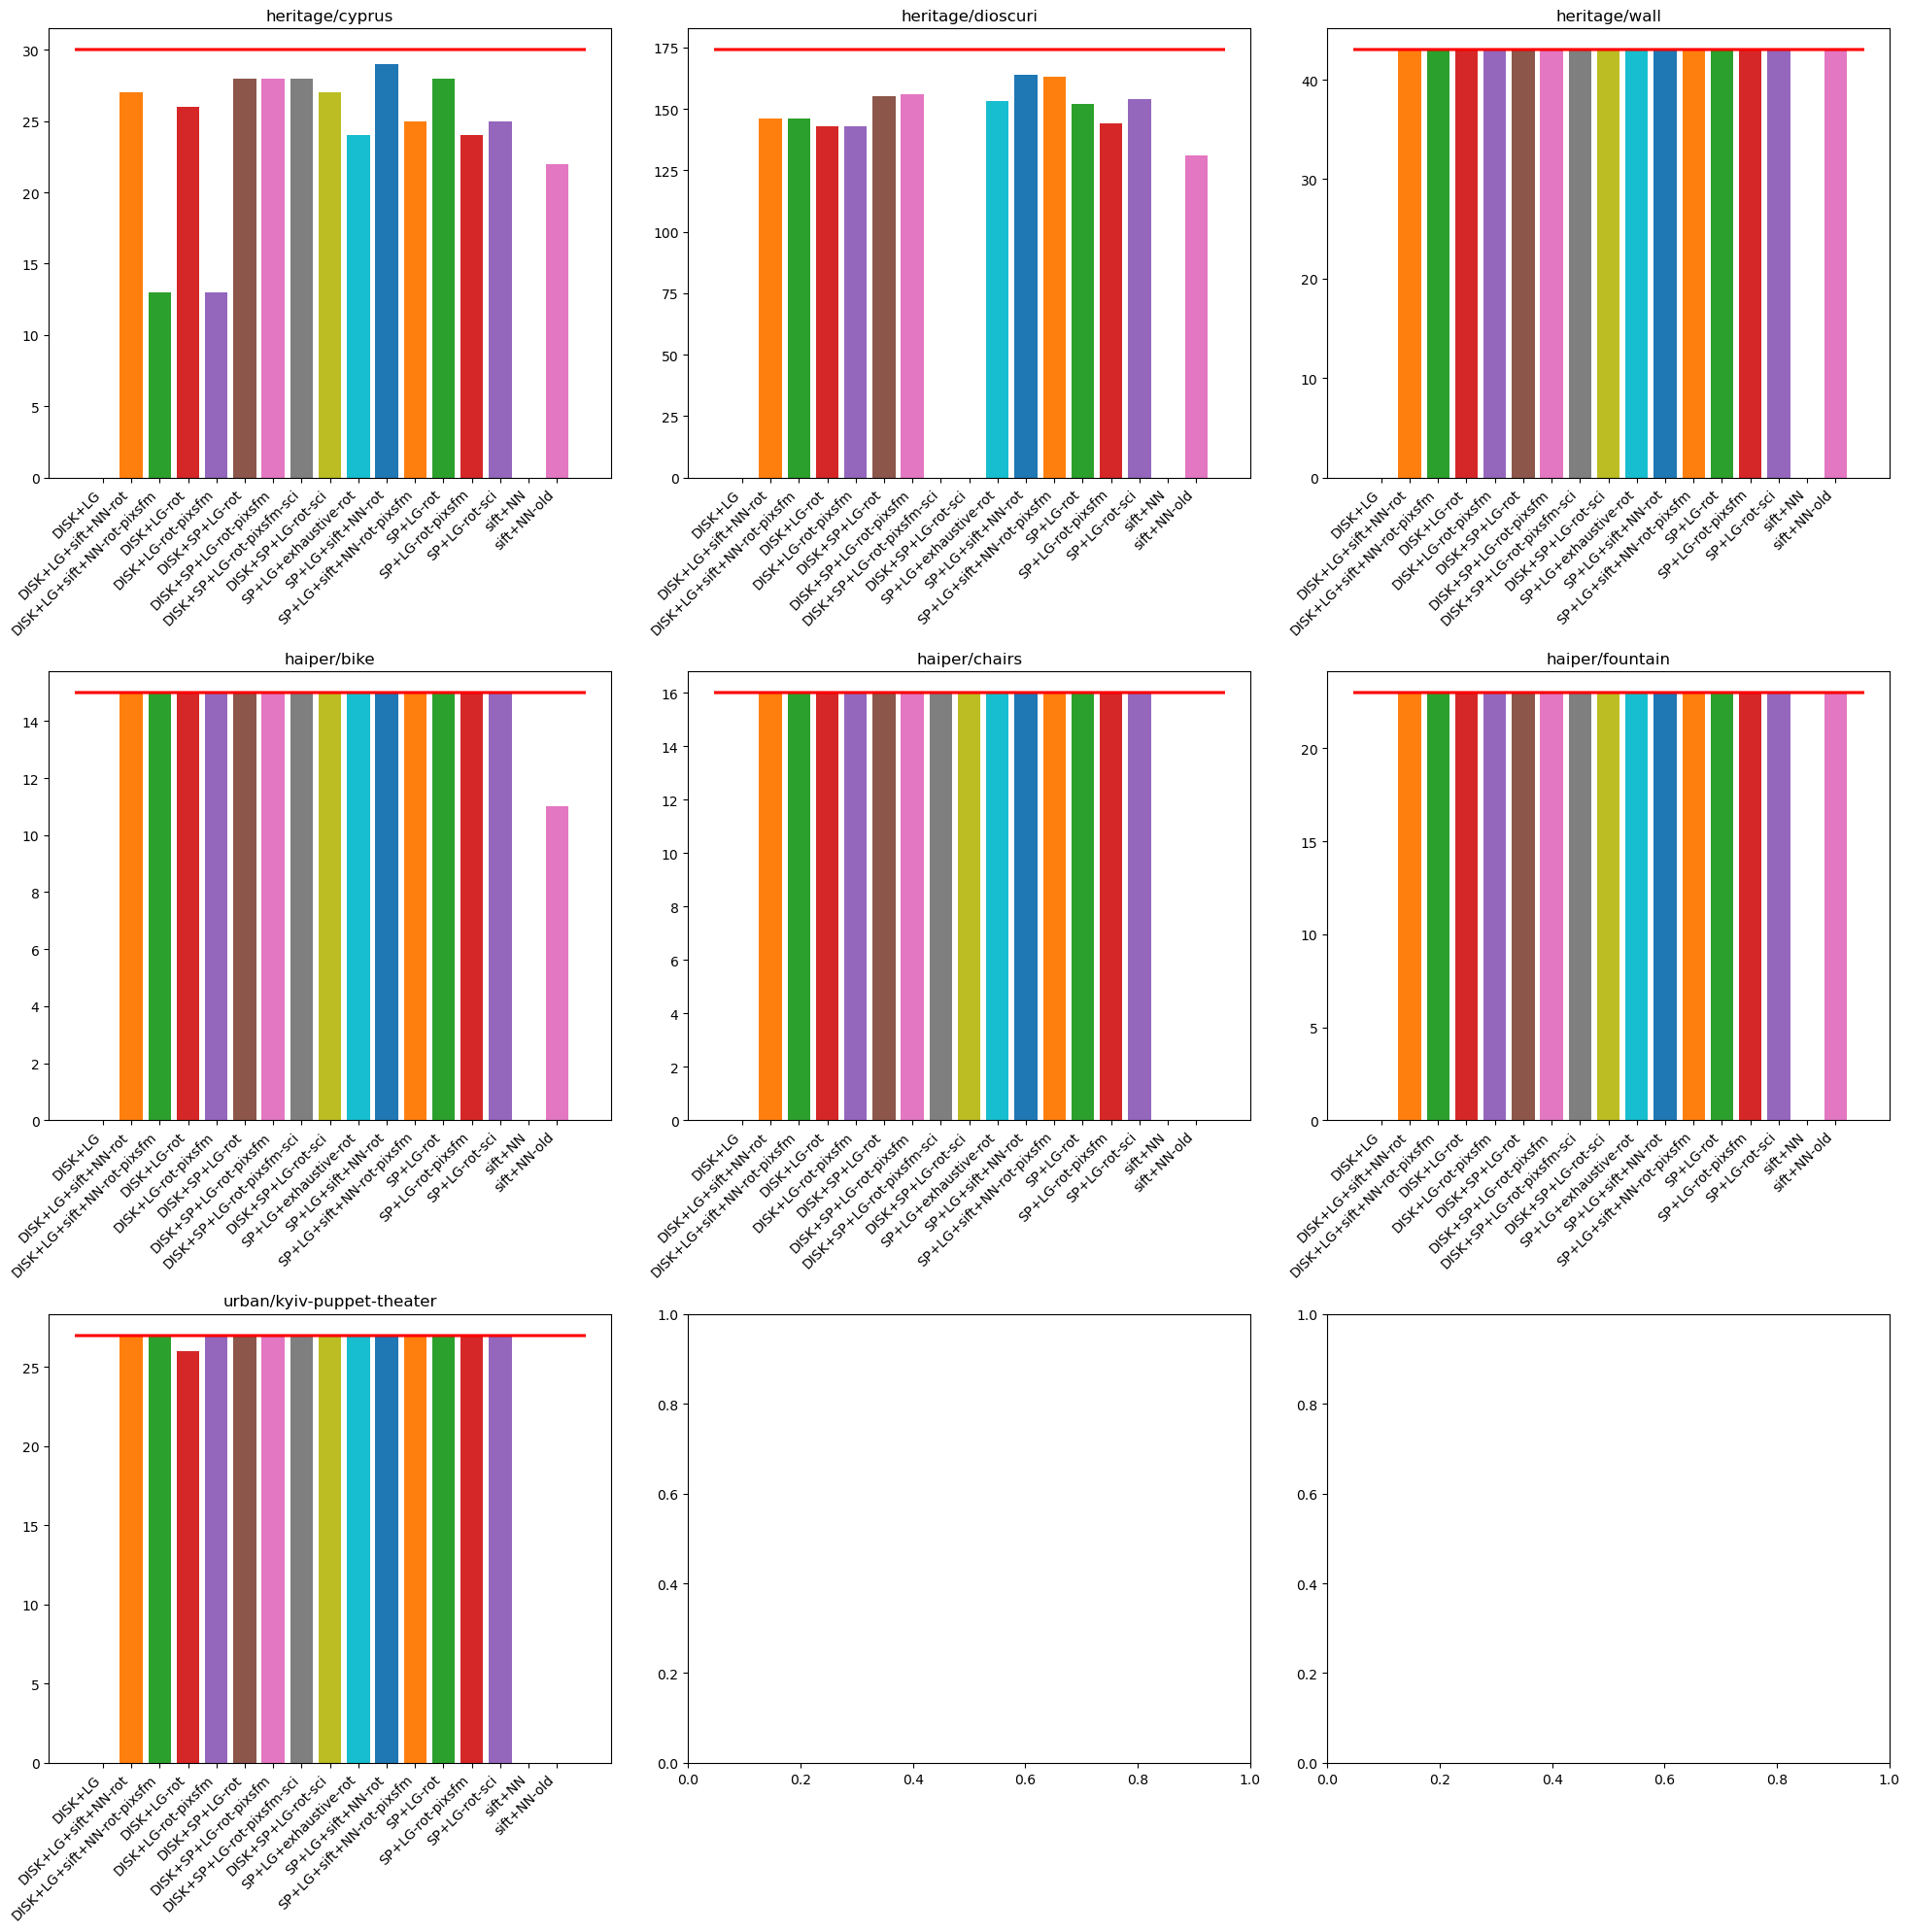

In [14]:
fig, ax = plt.subplots(len(datasets), len(datasets["heritage"]), figsize=(20, 20))

for i, ds in enumerate(datasets.keys()):
    for j, scene in enumerate(datasets[ds]):
        for r in df.index:
            name = df.loc[r, "run"]
            n_reg = df.loc[r, f"{ds}_{scene}_num_reg_images"]
            
            ax[i, j].bar(
                r,
                n_reg,
                label=f"{r}",
            )

            ax[i, j].hlines(
                len(metrics[ds][scene]["images"]),
                -1,
                len(runs),
                label=f"GT ({len(metrics[ds][scene]['images'])})",
                colors="r",
            )
            
            ax[i, j].set_title(f"{ds}/{scene}")

            # rotate x-axis labels and align them to the right
            for tick in ax[i, j].get_xticklabels():
                tick.set_rotation(45)
                tick.set_ha("right")

plt.tight_layout()
plt.show()

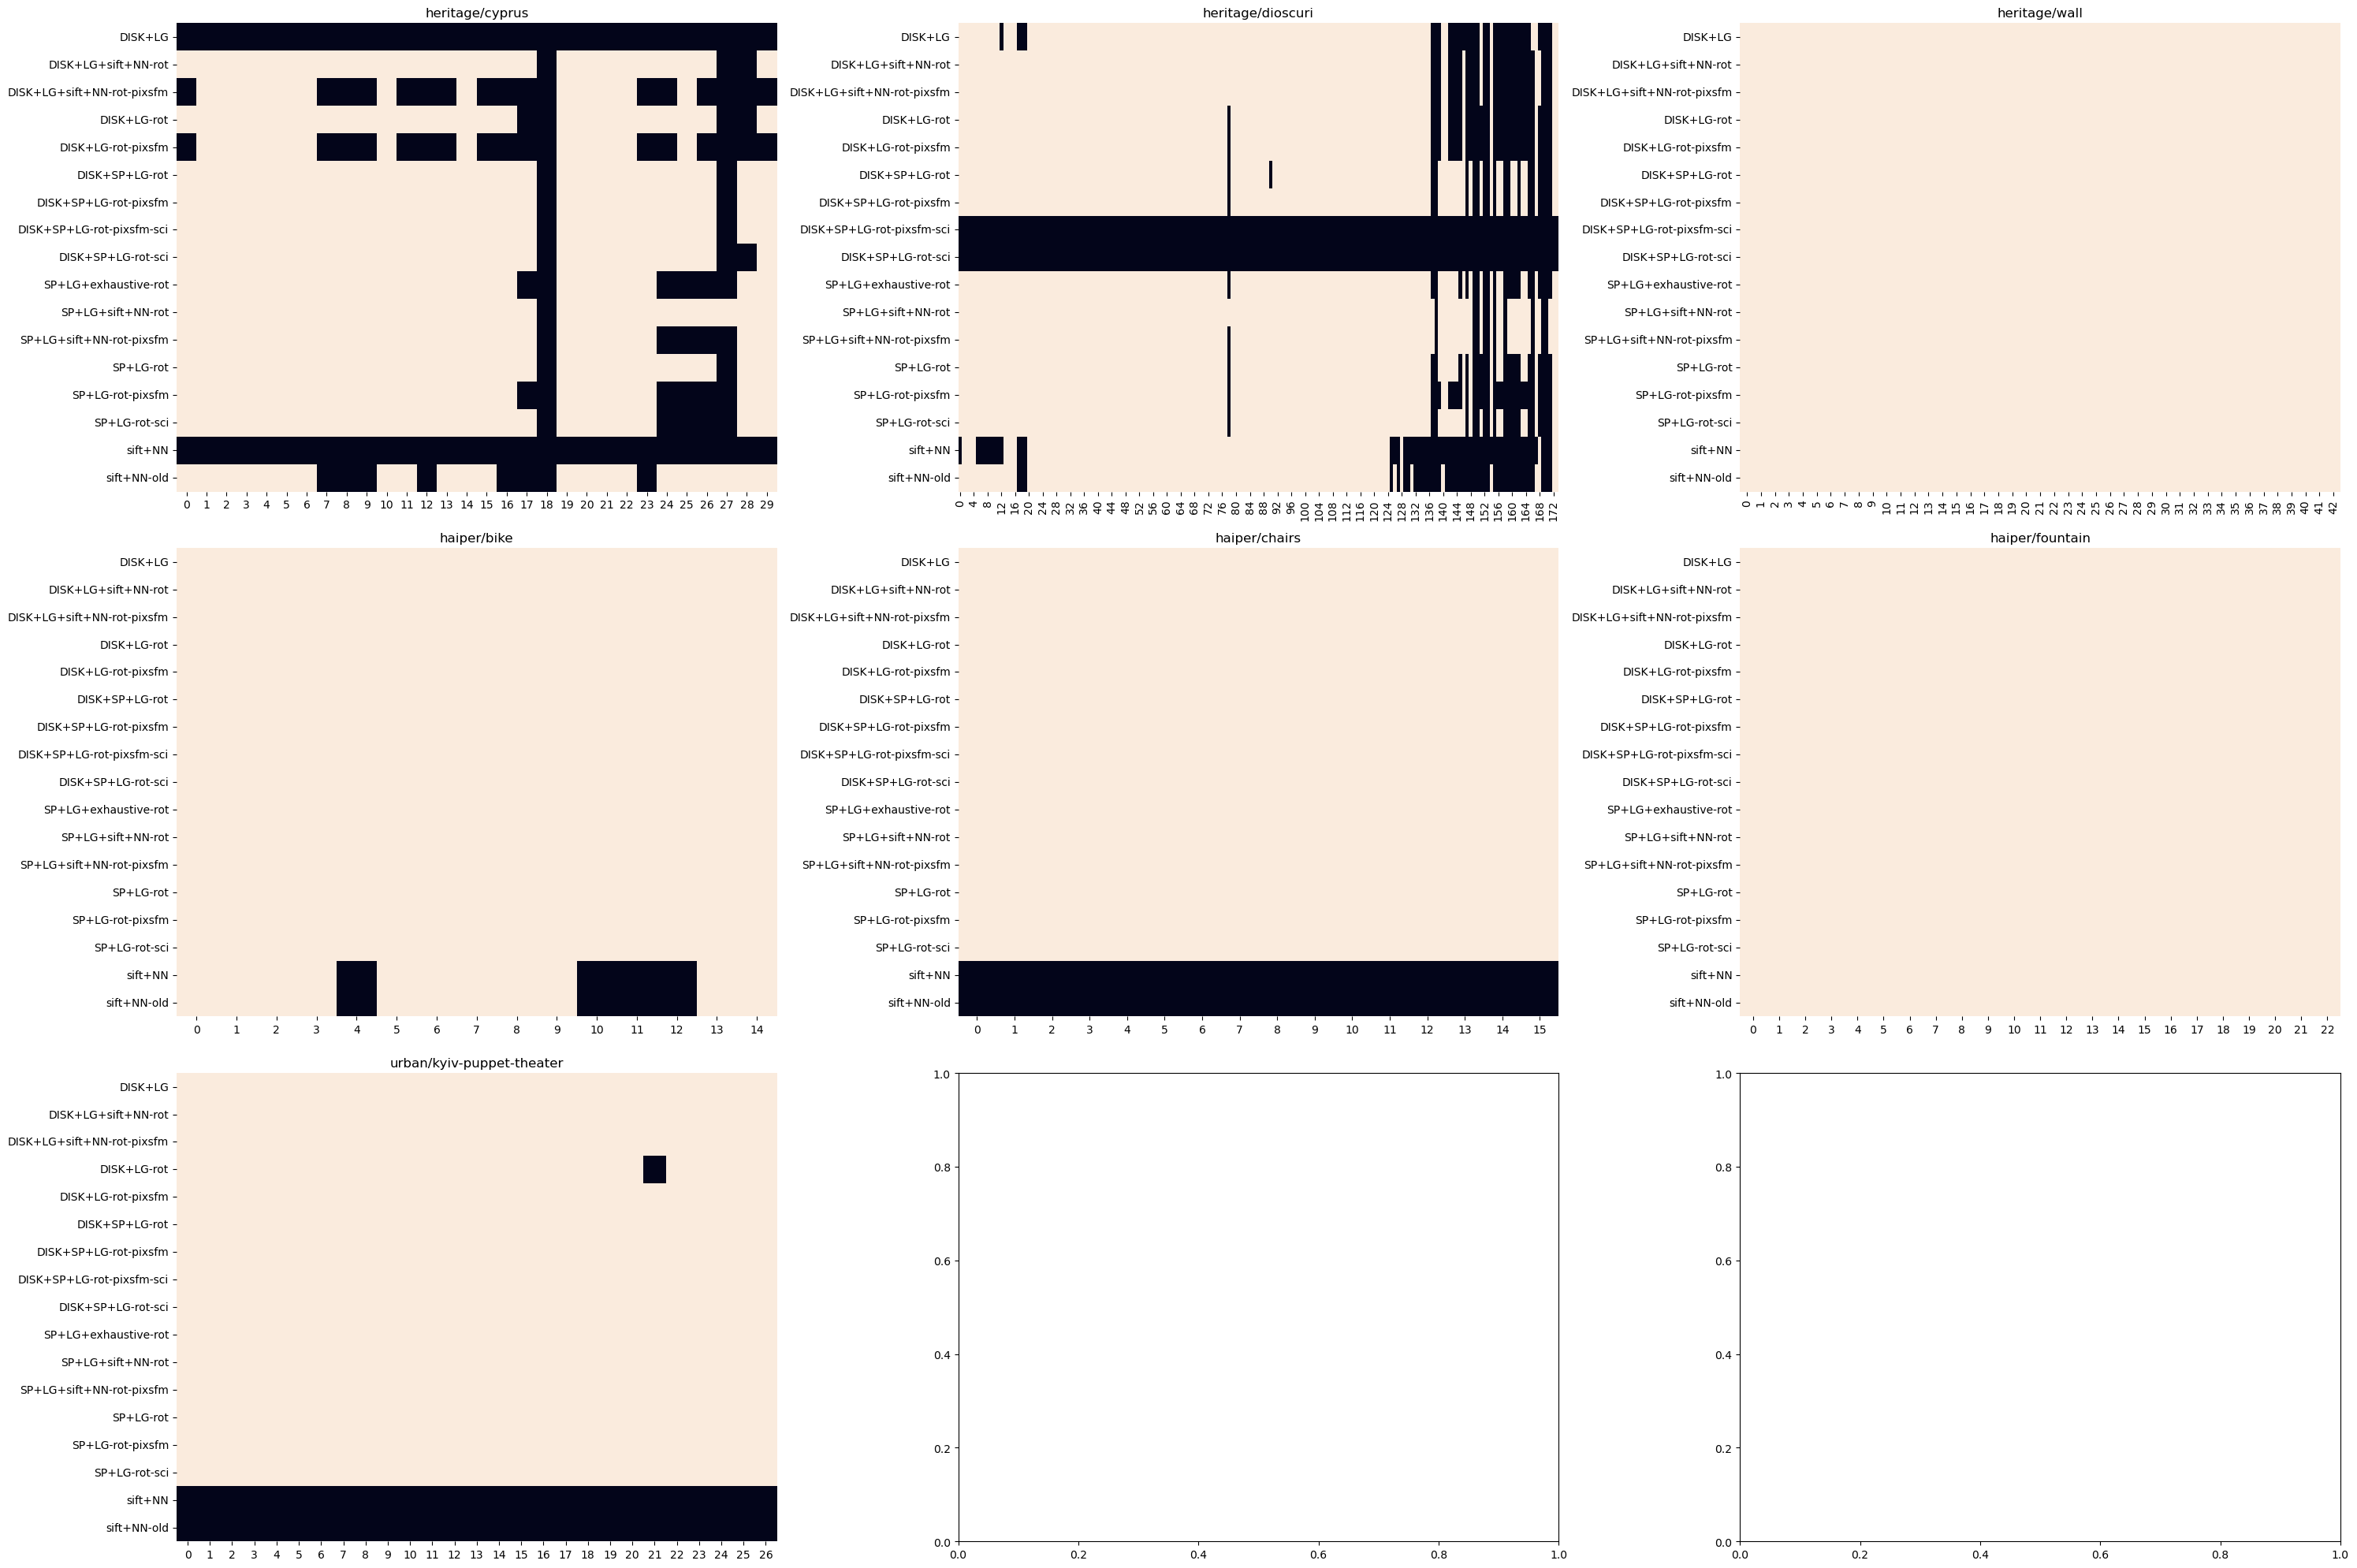

In [26]:
fig, ax = plt.subplots(len(datasets), len(datasets["heritage"]), figsize=(30, 20))

for i, ds in enumerate(datasets.keys()):
    for j, scene in enumerate(datasets[ds]):
        bool_img_run = np.zeros((len(runs), len(metrics[ds][scene]["images"])))
        
        for r_idx, r in enumerate(runs):
            if r not in metrics[ds][scene].keys():
                continue

            for img in metrics[ds][scene][r]["reg_images"]:
                img_idx = metrics[ds][scene]["images"].index(img)
                bool_img_run[r_idx, img_idx] = 1

        sns.heatmap(
            bool_img_run,
            ax=ax[i, j],
            cbar=False,
            vmin=0,
            vmax=1,
            yticklabels=runs,
        )
        ax[i, j].set_title(f"{ds}/{scene}")

# add more space between plots
plt.tight_layout()
plt.show()

## Compare Runtimes

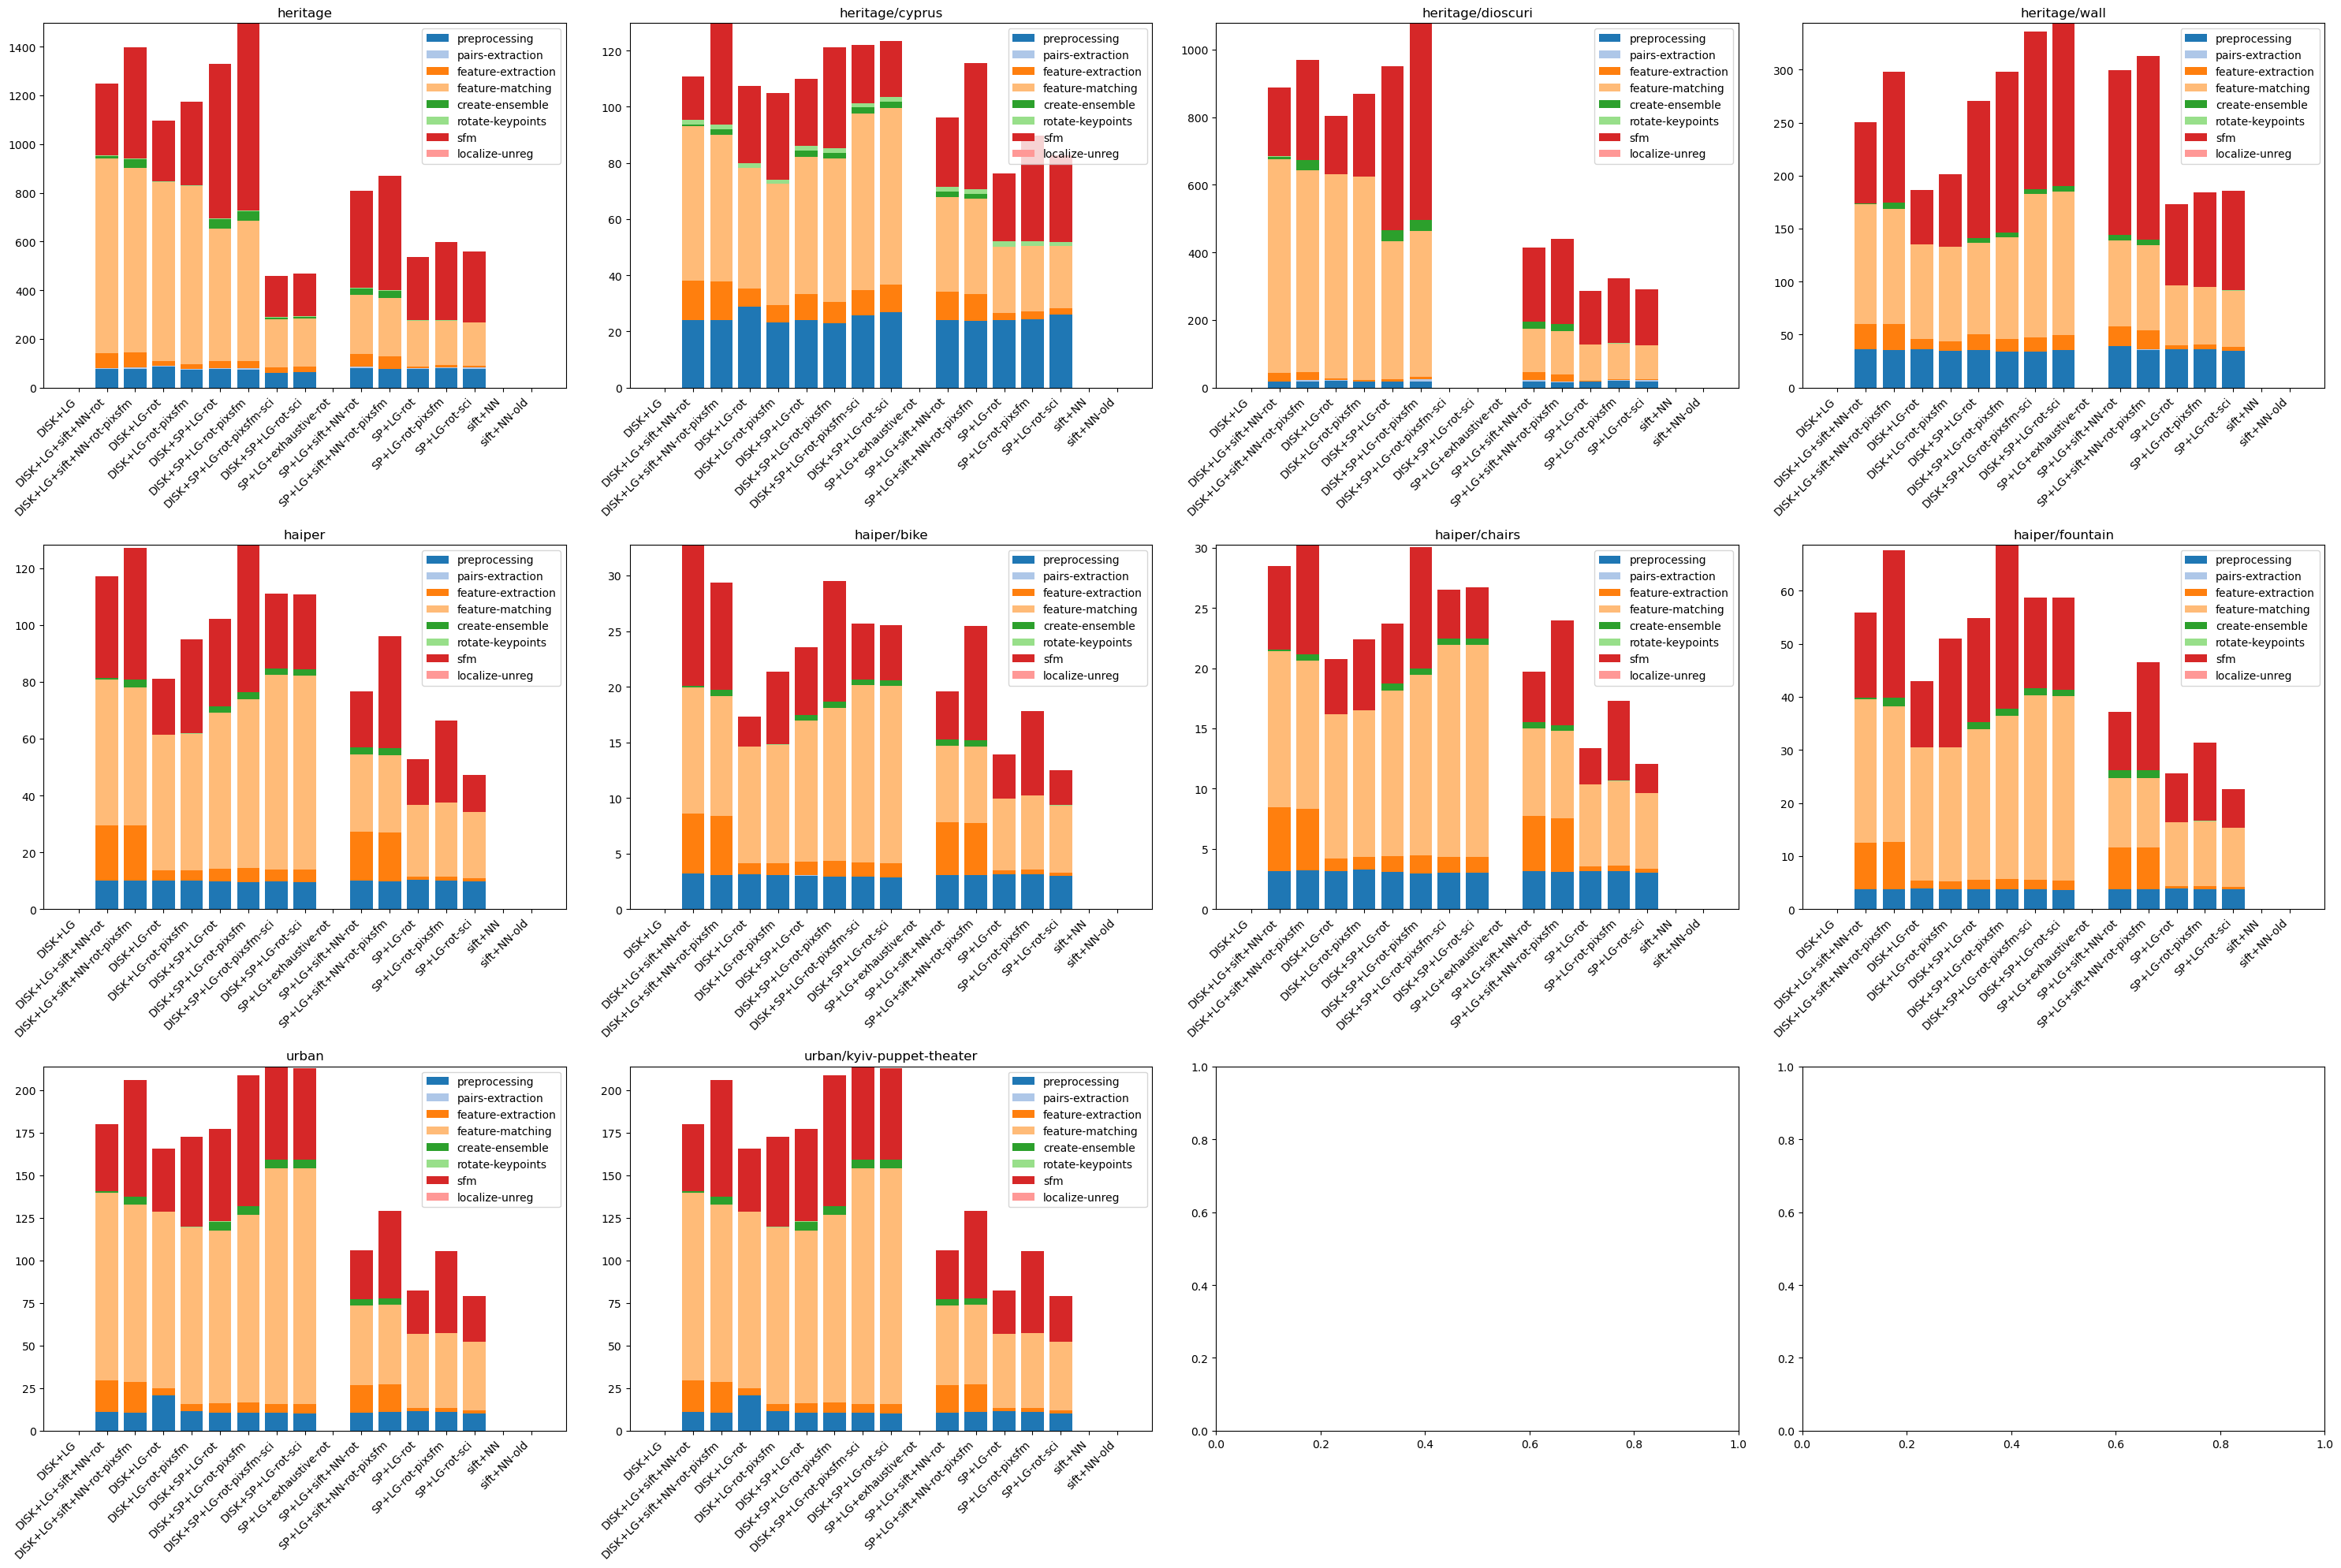

In [25]:
fig, ax = plt.subplots(len(datasets), len(datasets["heritage"])+1, figsize=(30, 20))

cmap = plt.get_cmap("tab20") 

for i, ds in enumerate(datasets.keys()):
    for r in df.index:
        name = df.loc[r, "run"]
        mean_times = [0 for _ in pipline_steps]
        for scene in datasets[ds]:
            for idx, step in enumerate(pipline_steps):
                mean_times[idx] += df.loc[r, f"{ds}_{scene}_{step}_time"]
        mean_times = [t / len(datasets[ds]) for t in mean_times]

        cumsum = 0
        for idx, step in enumerate(pipline_steps):
            ax[i, 0].bar(
                name,
                mean_times[idx],
                bottom=cumsum,
                label=step if r == df.index[-1] else "",
                color=cmap(idx),
            )
            cumsum += mean_times[idx]

        # rotate the xticklabels
        for tick in ax[i, 0].get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha("right")

    ax[i, 0].set_title(ds)
    ax[i, 0].legend()


    for j, scene in enumerate(datasets[ds]):
        for r in df.index:
            name = df.loc[r, "run"]
            mean_times = [0 for _ in pipline_steps]
            for idx, step in enumerate(pipline_steps):
                mean_times[idx] += df.loc[r, f"{ds}_{scene}_{step}_time"]
            mean_times = [t / len(datasets[ds]) for t in mean_times]

            cumsum = 0
            for idx, step in enumerate(pipline_steps):
                ax[i, j+1].bar(
                    name,
                    mean_times[idx],
                    bottom=cumsum,
                    label=step if r == df.index[-1] else "",
                    color=cmap(idx),
                )
                cumsum += mean_times[idx]

            # rotate x-axis labels and align them to the right
            for tick in ax[i, j+1].get_xticklabels():
                tick.set_rotation(45)
                tick.set_ha("right")

        ax[i, j+1].set_title(f"{ds}/{scene}")
        ax[i, j+1].legend()

plt.tight_layout()
plt.show()

## Explore matches

heritage/cyprus: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s]


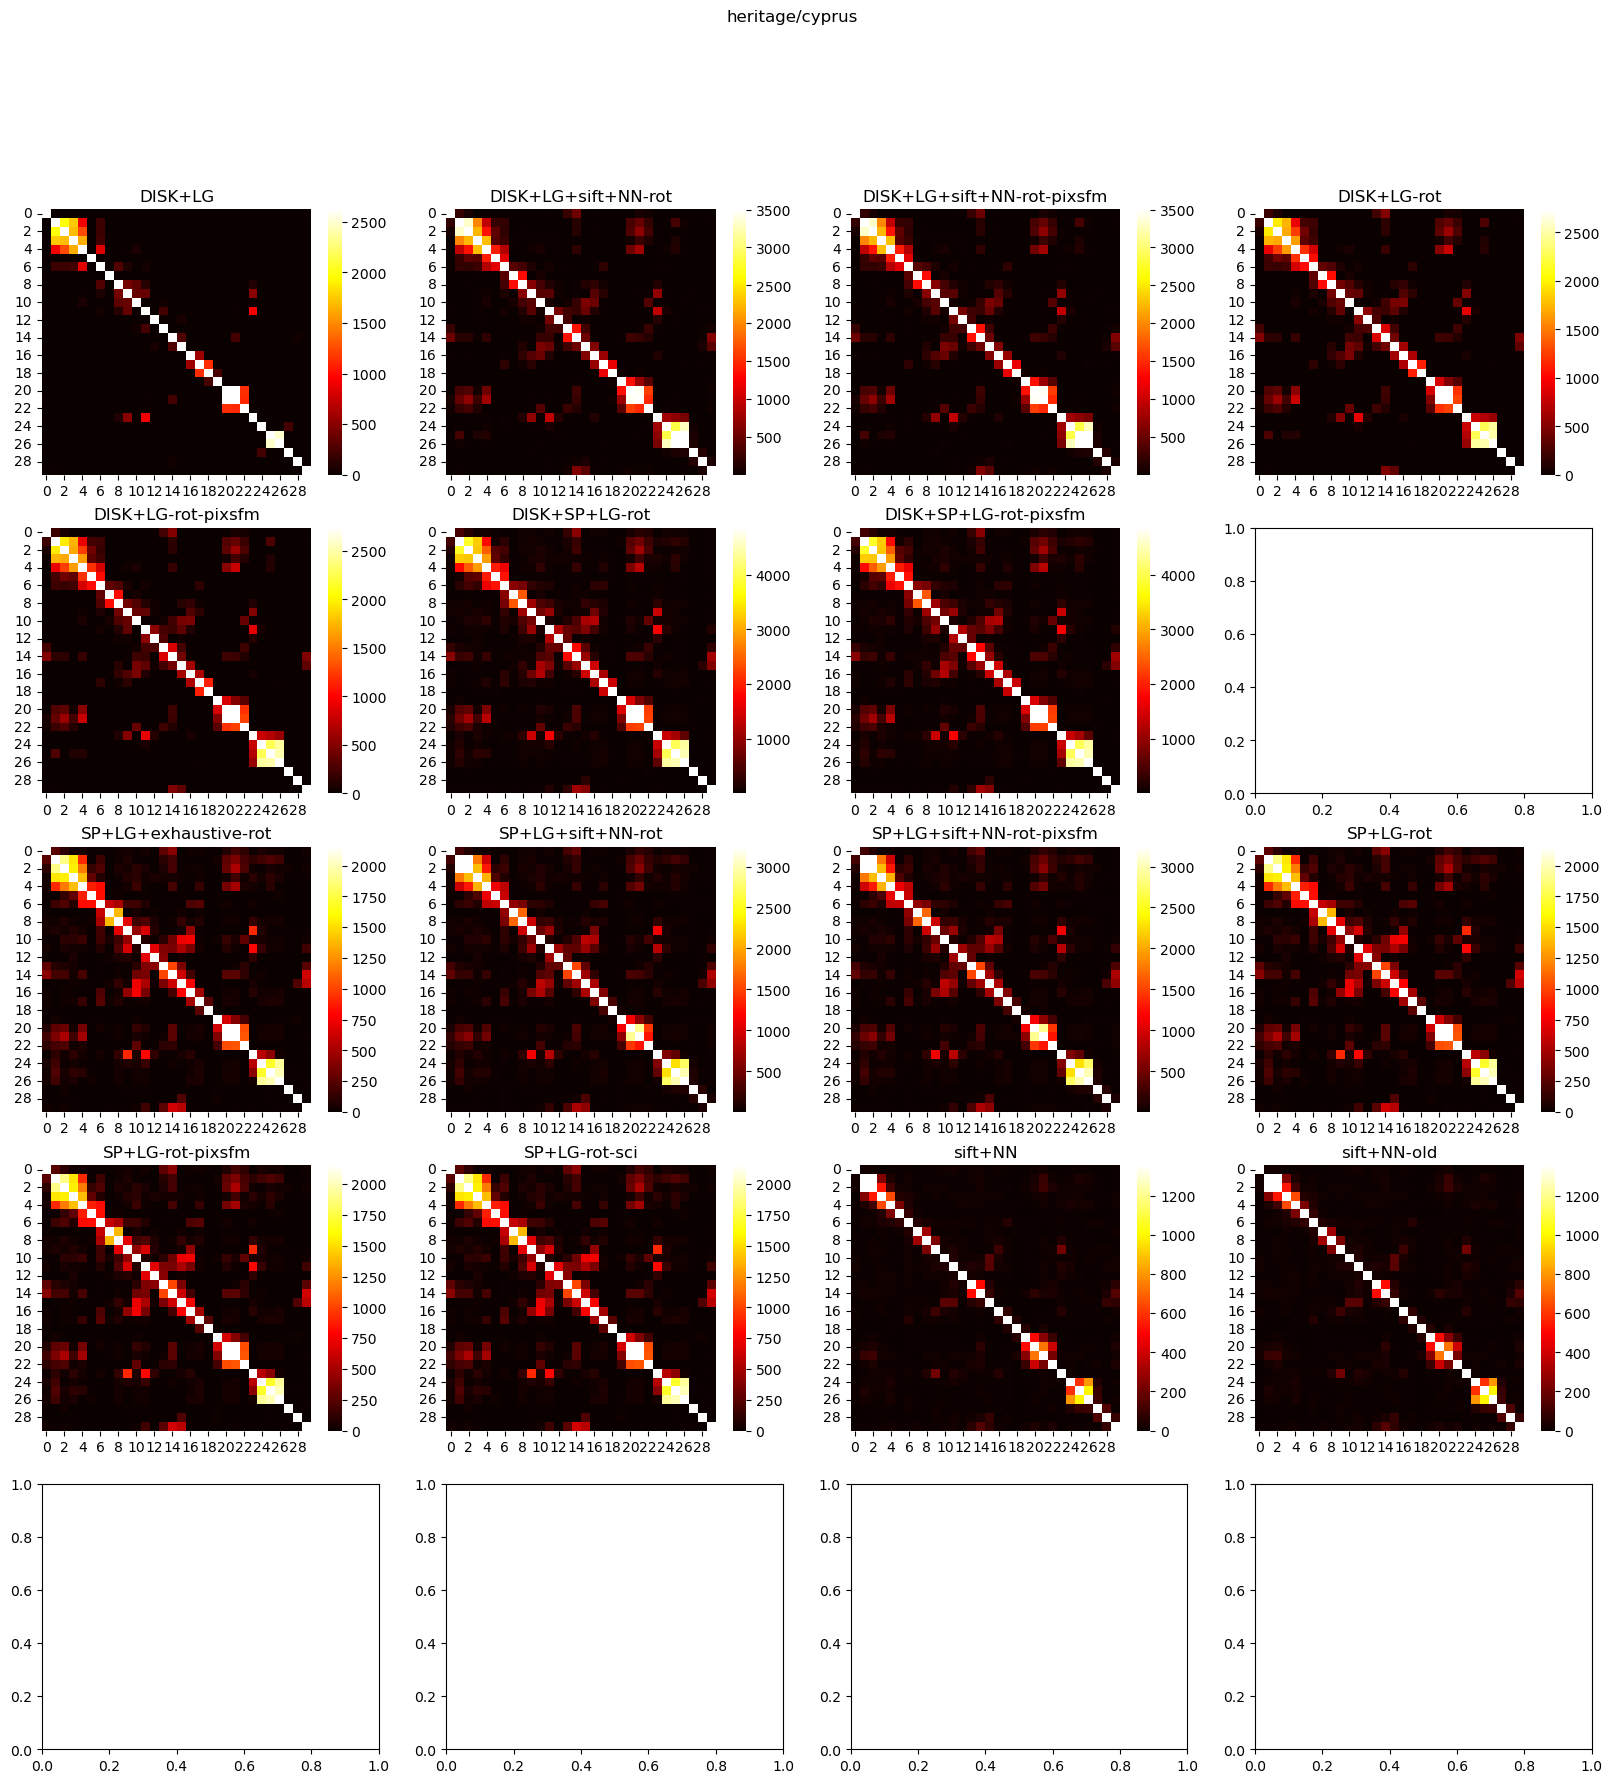

heritage/dioscuri: 100%|██████████| 16/16 [01:01<00:00,  3.87s/it]


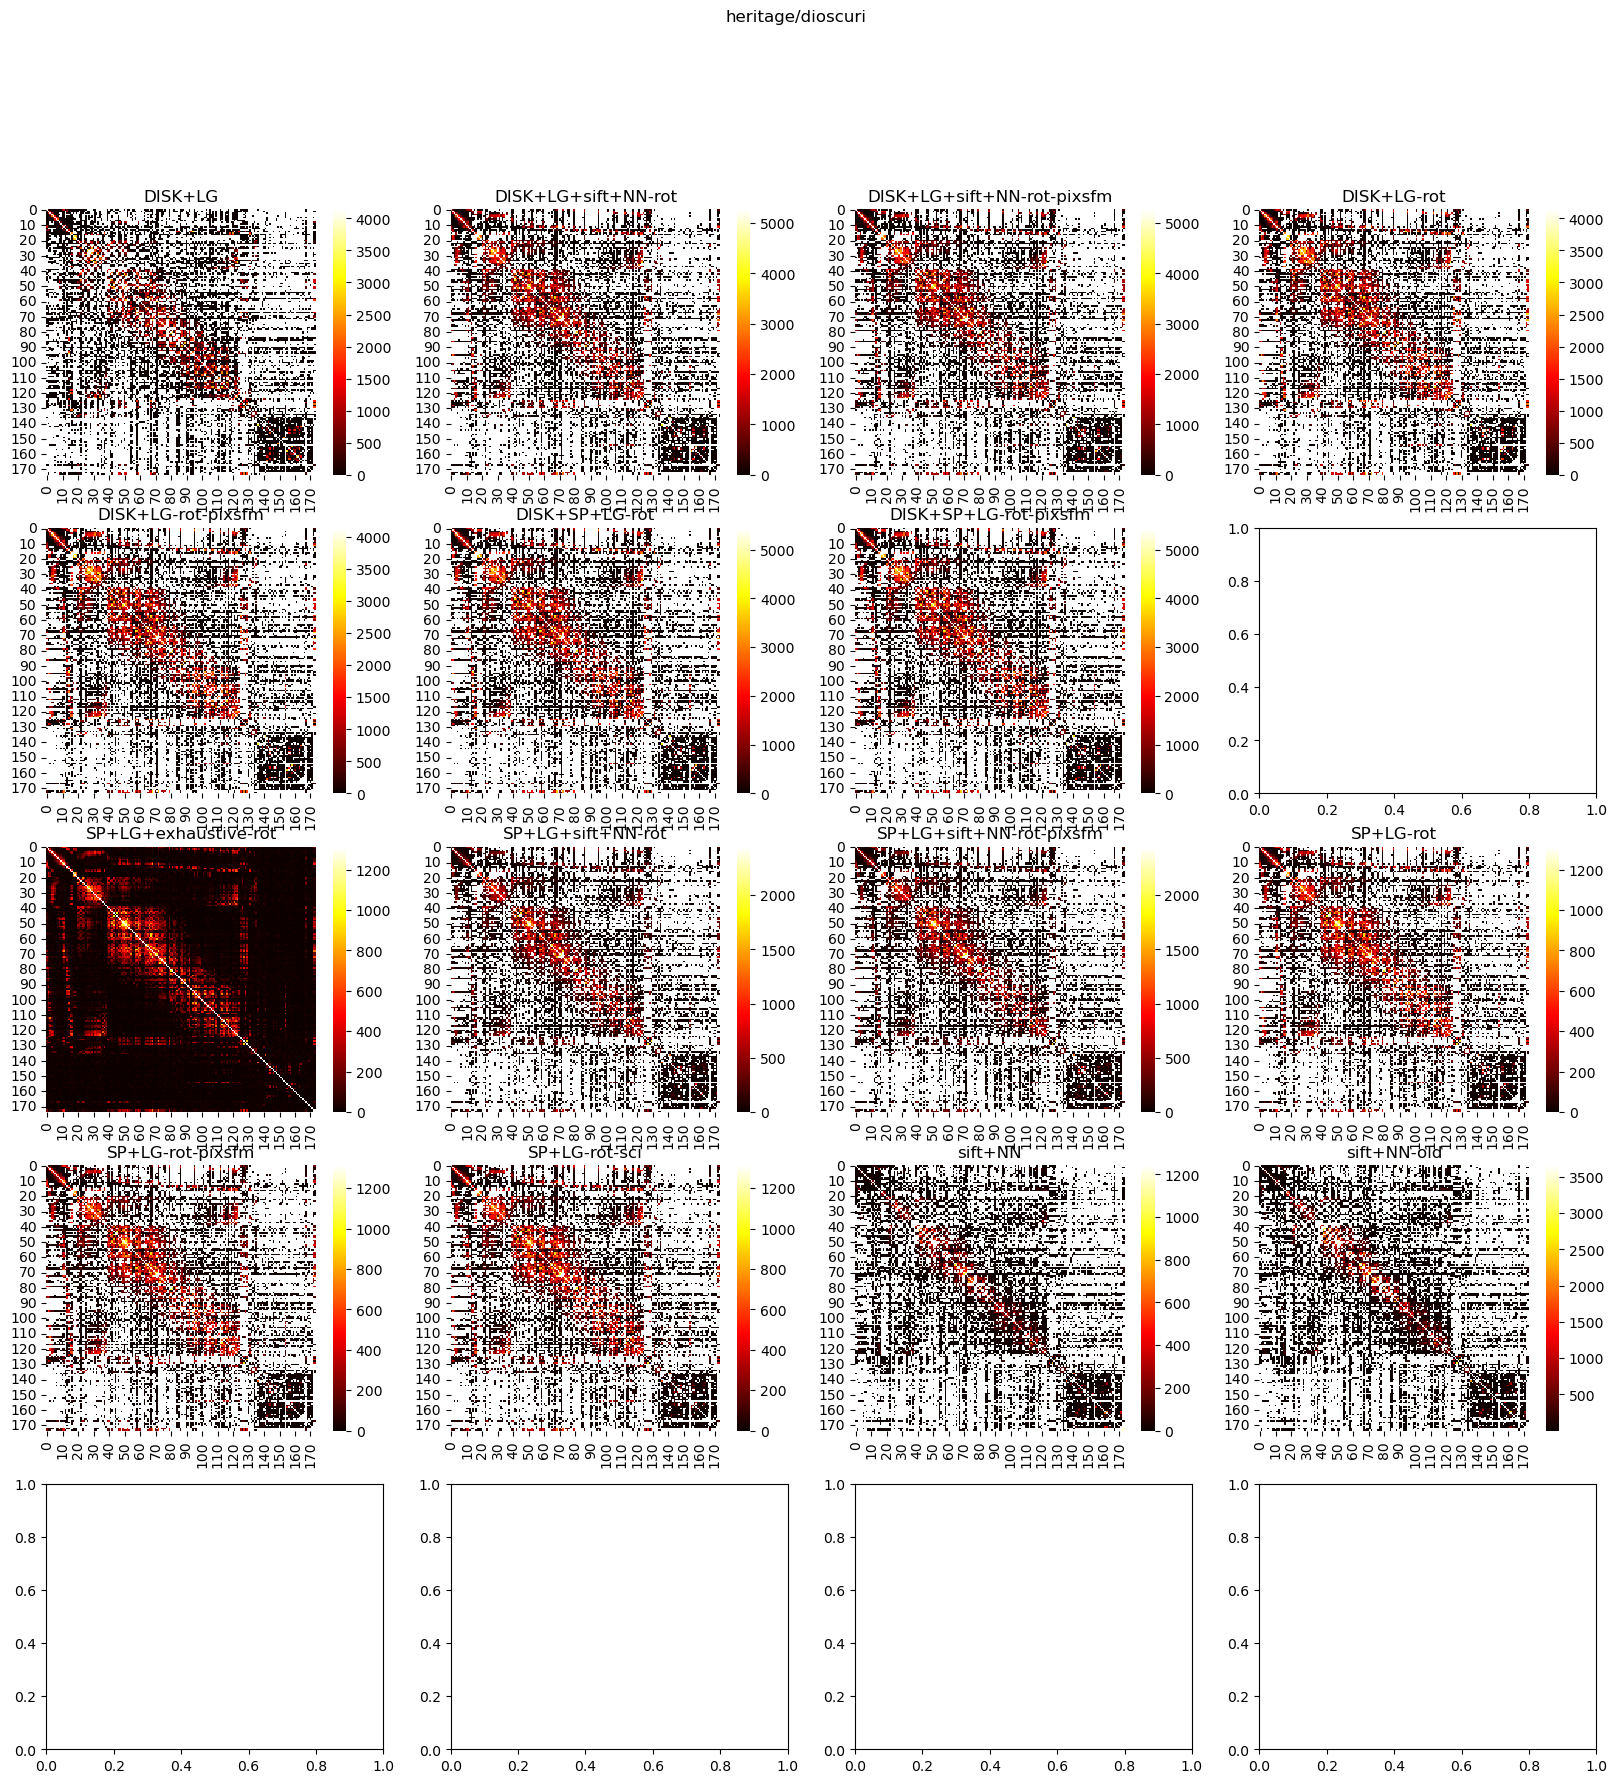

heritage/wall: 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


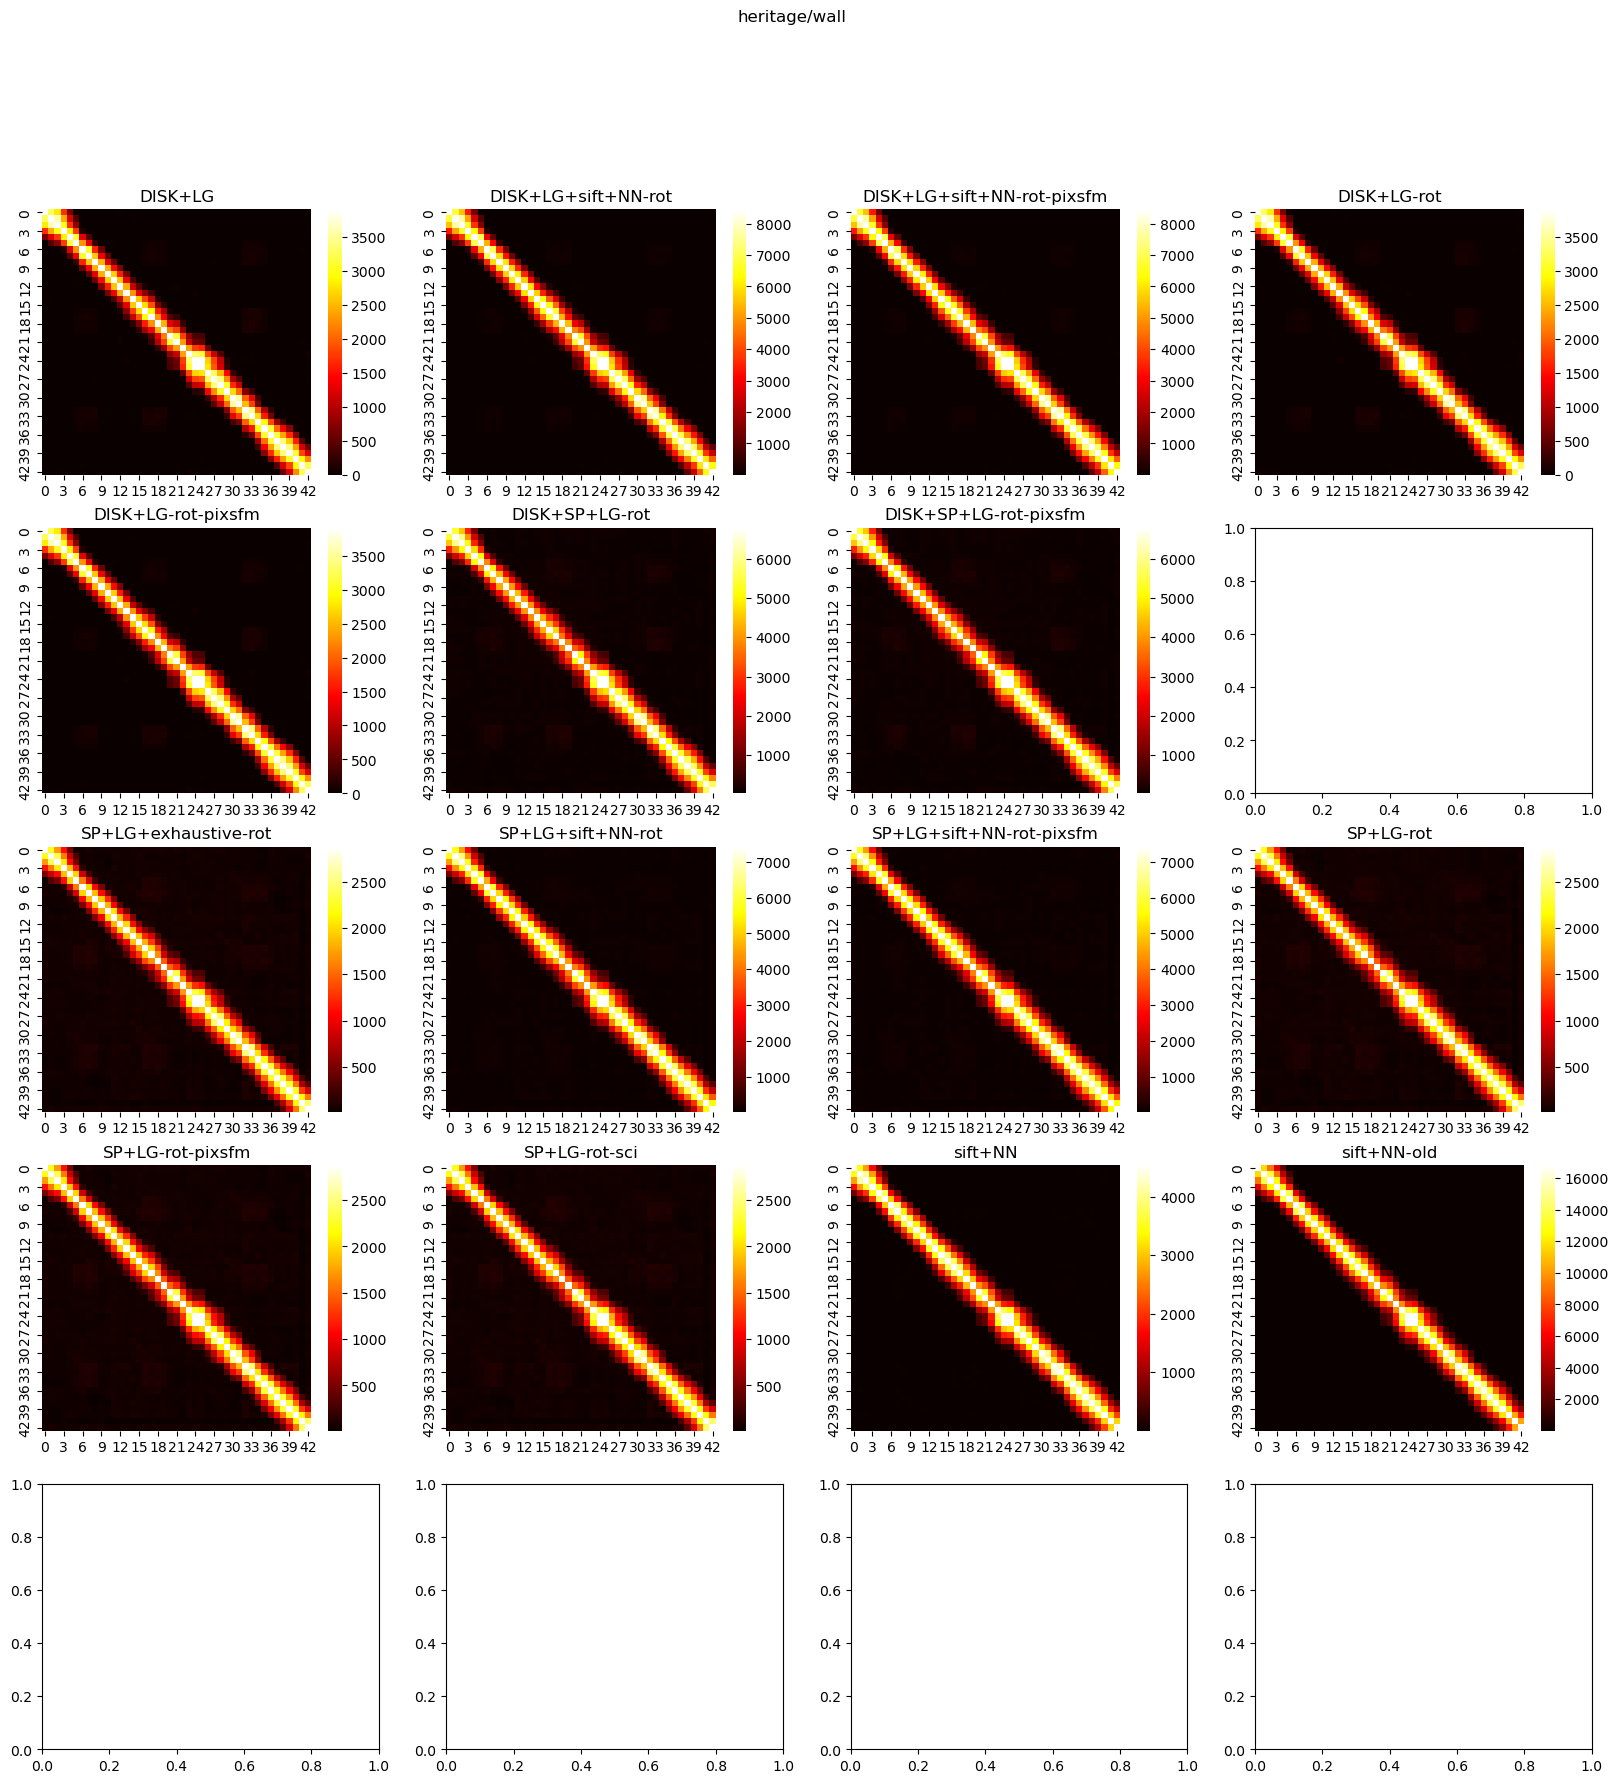

haiper/bike: 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]


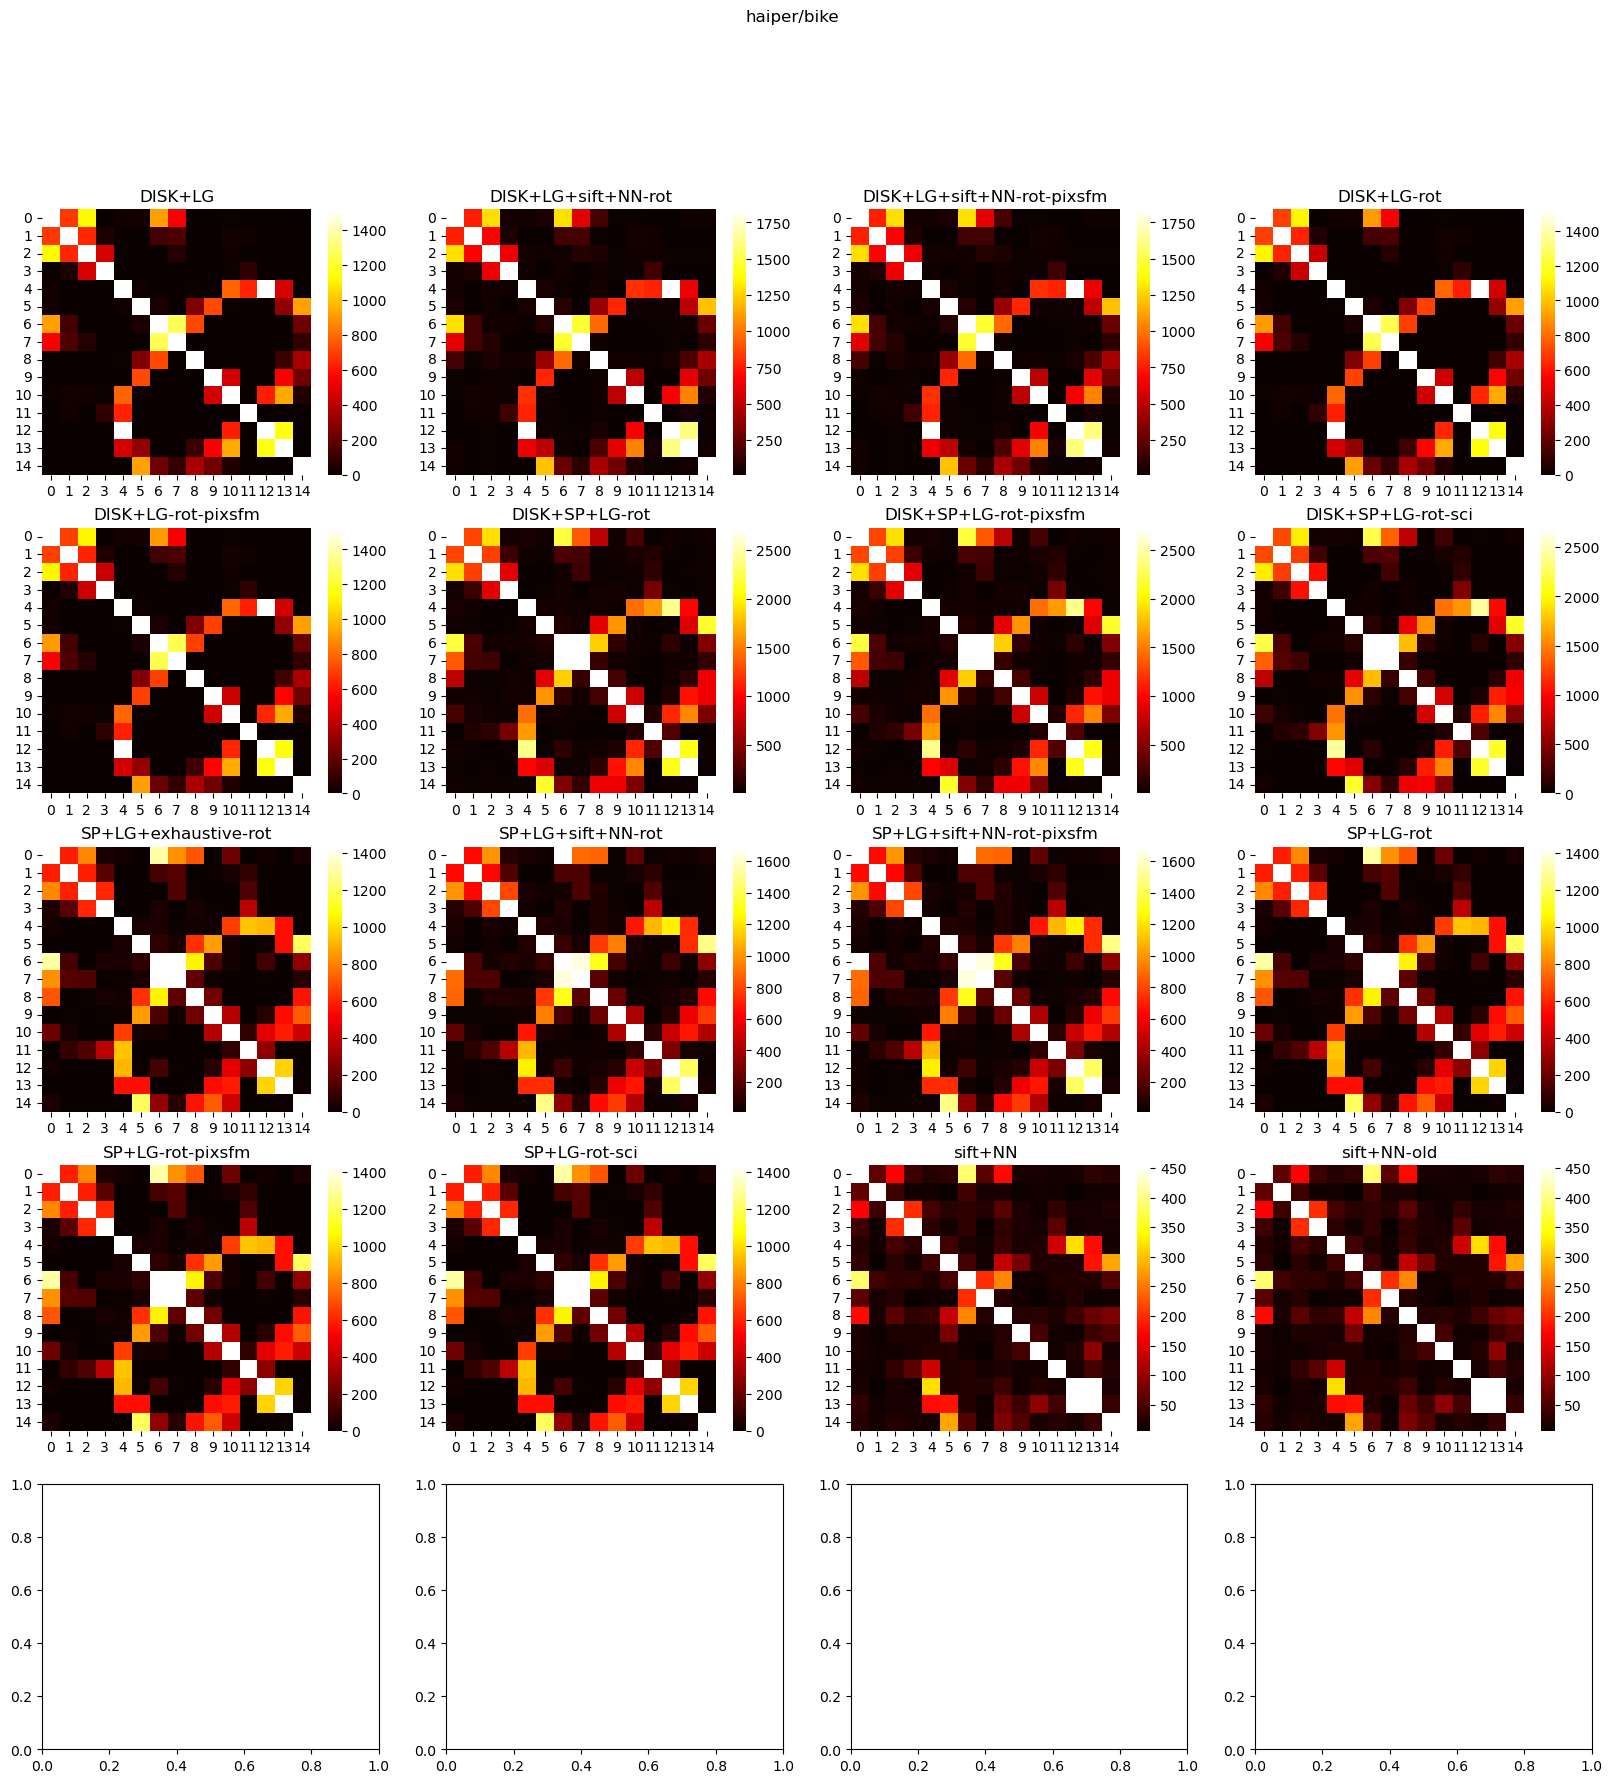

haiper/chairs: 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]


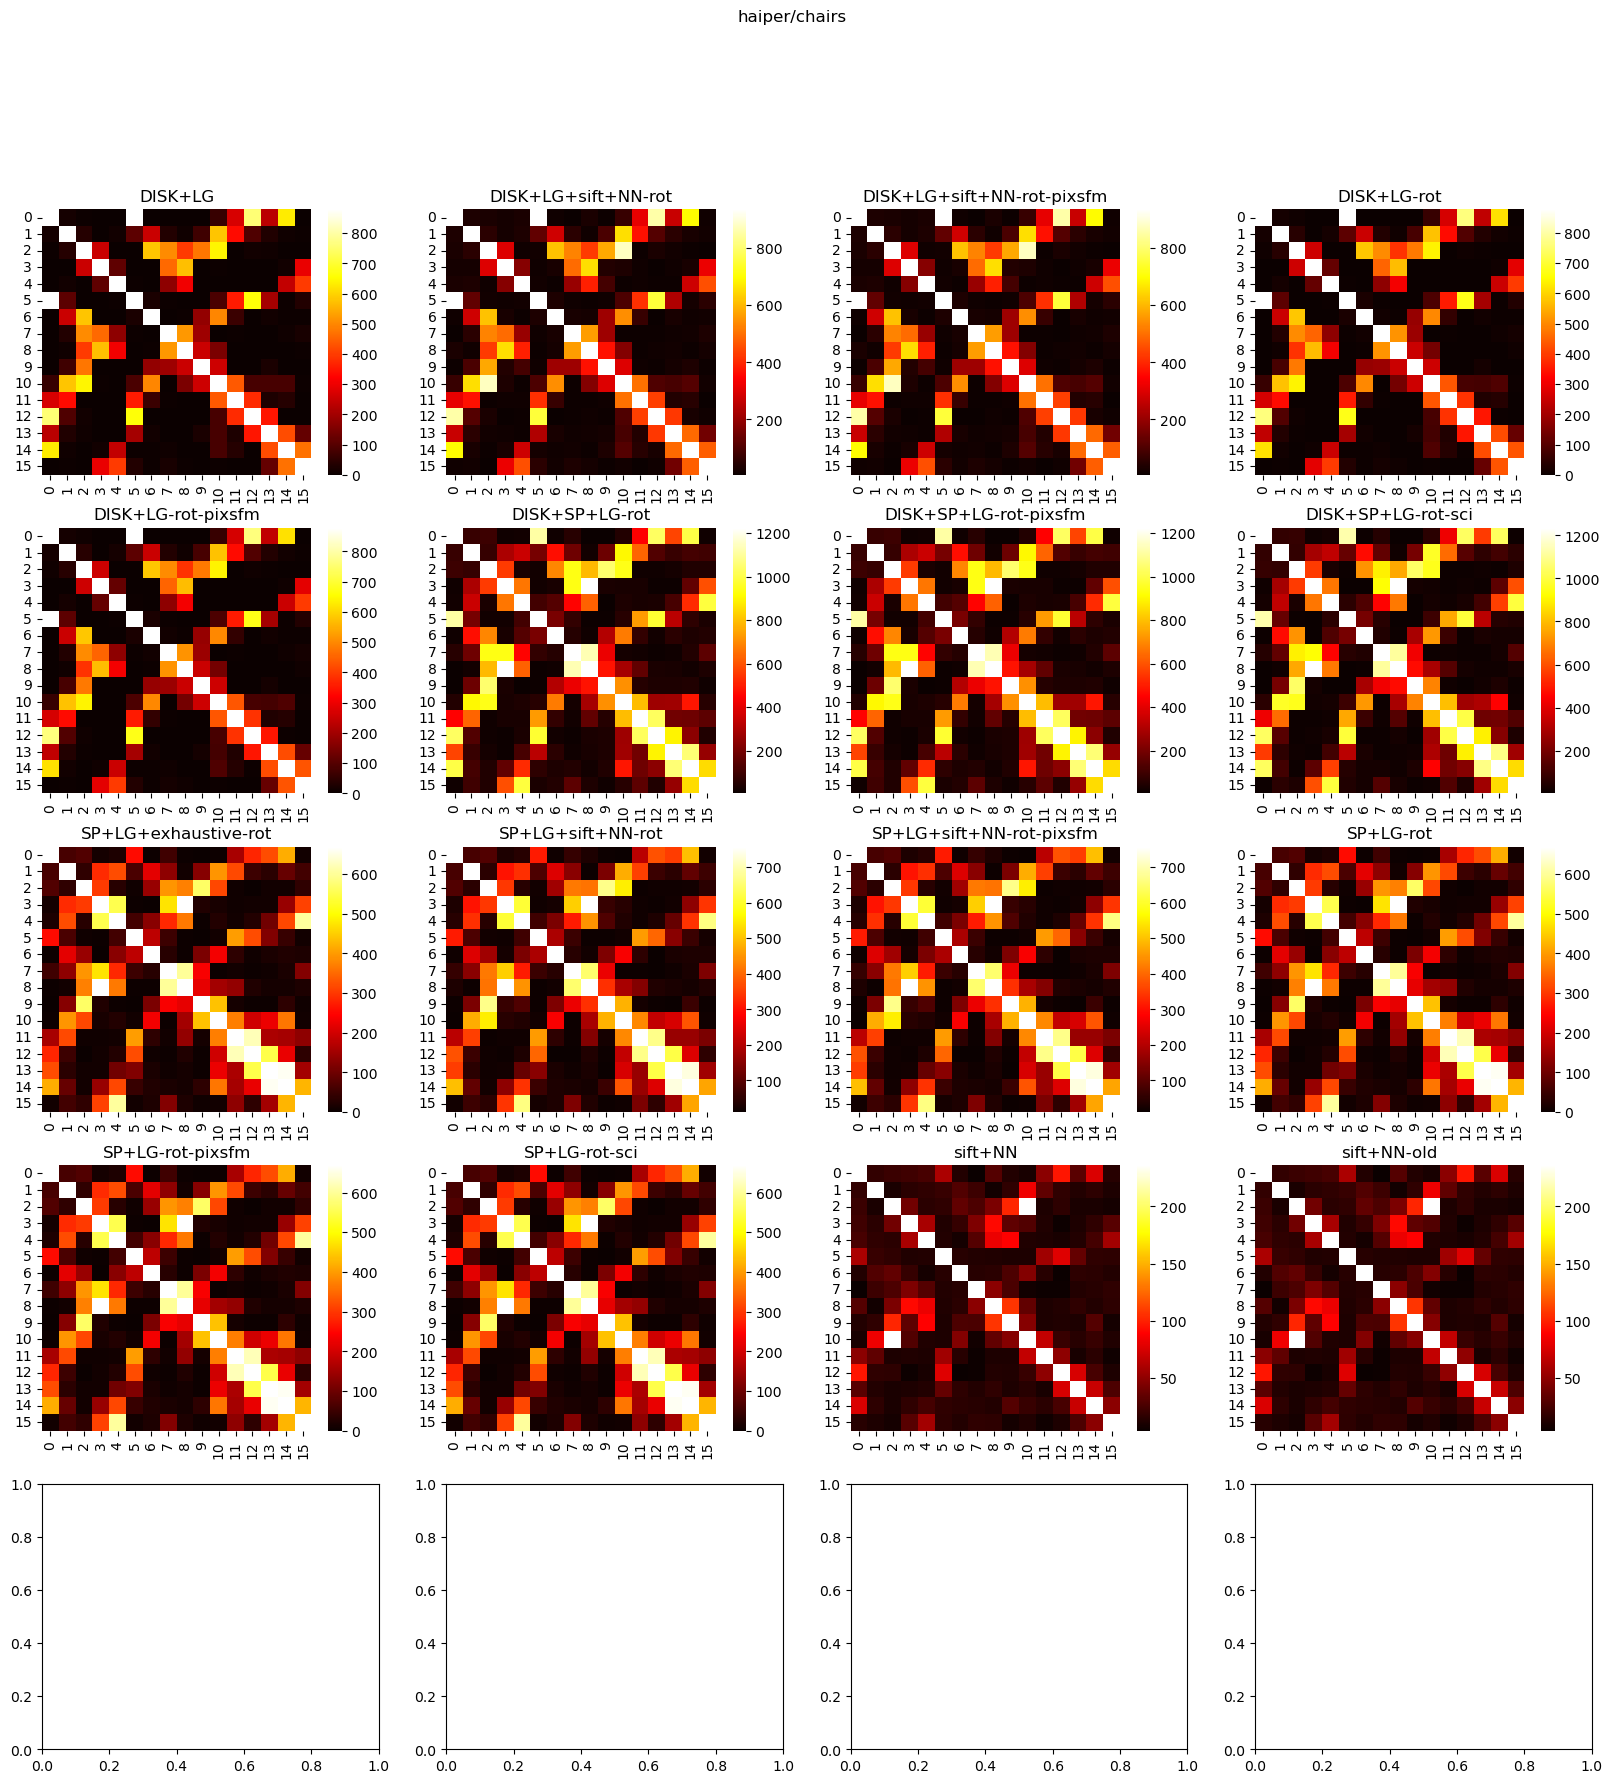

haiper/fountain: 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]


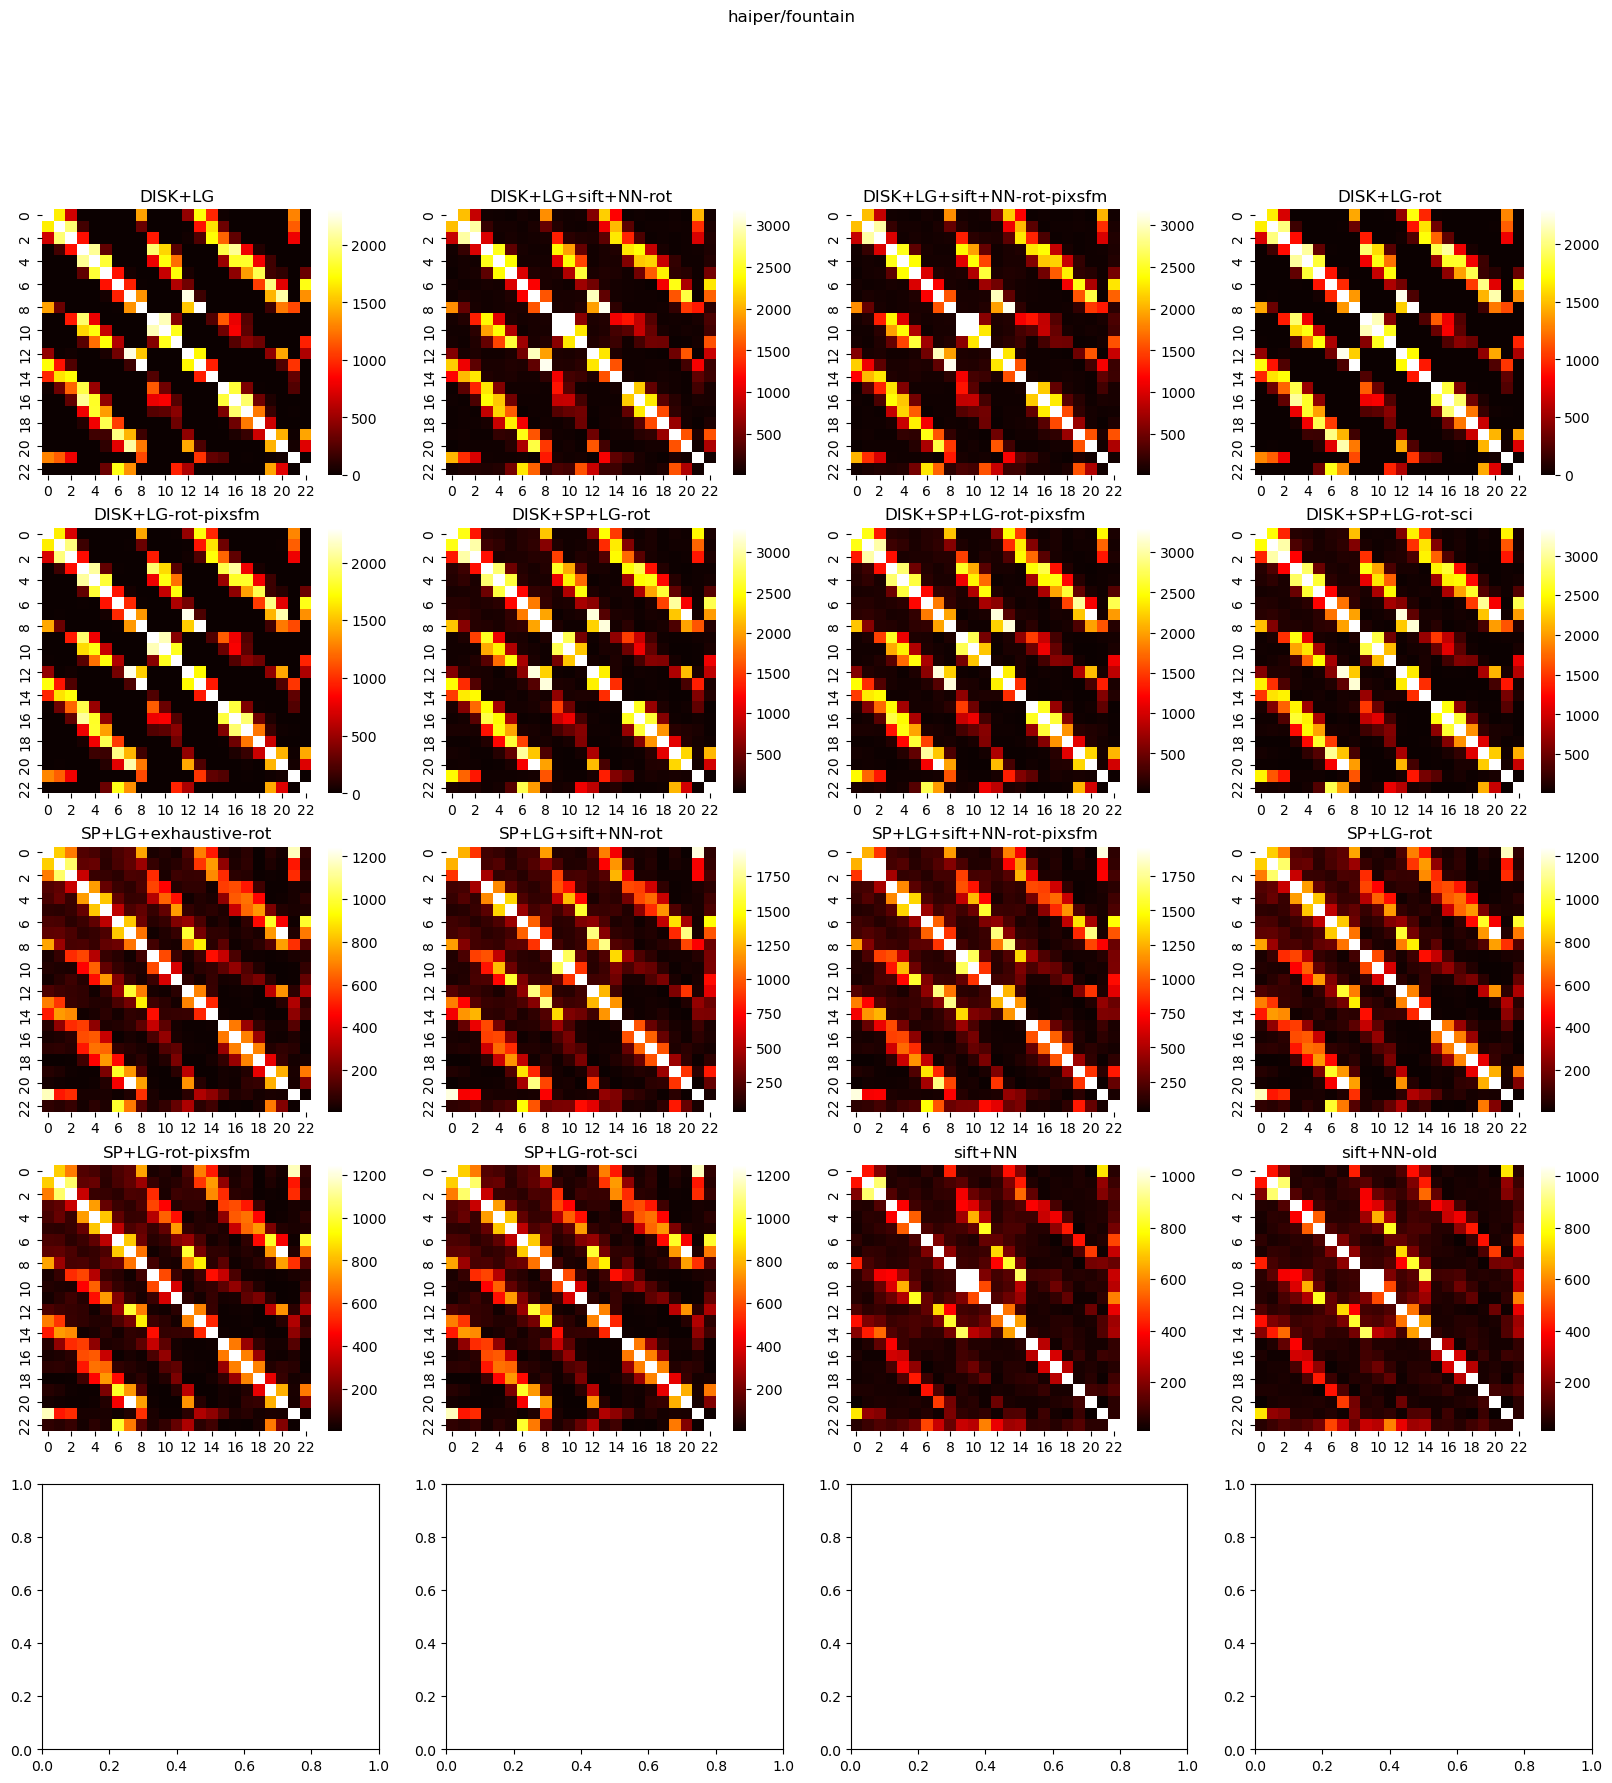

urban/kyiv-puppet-theater: 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]


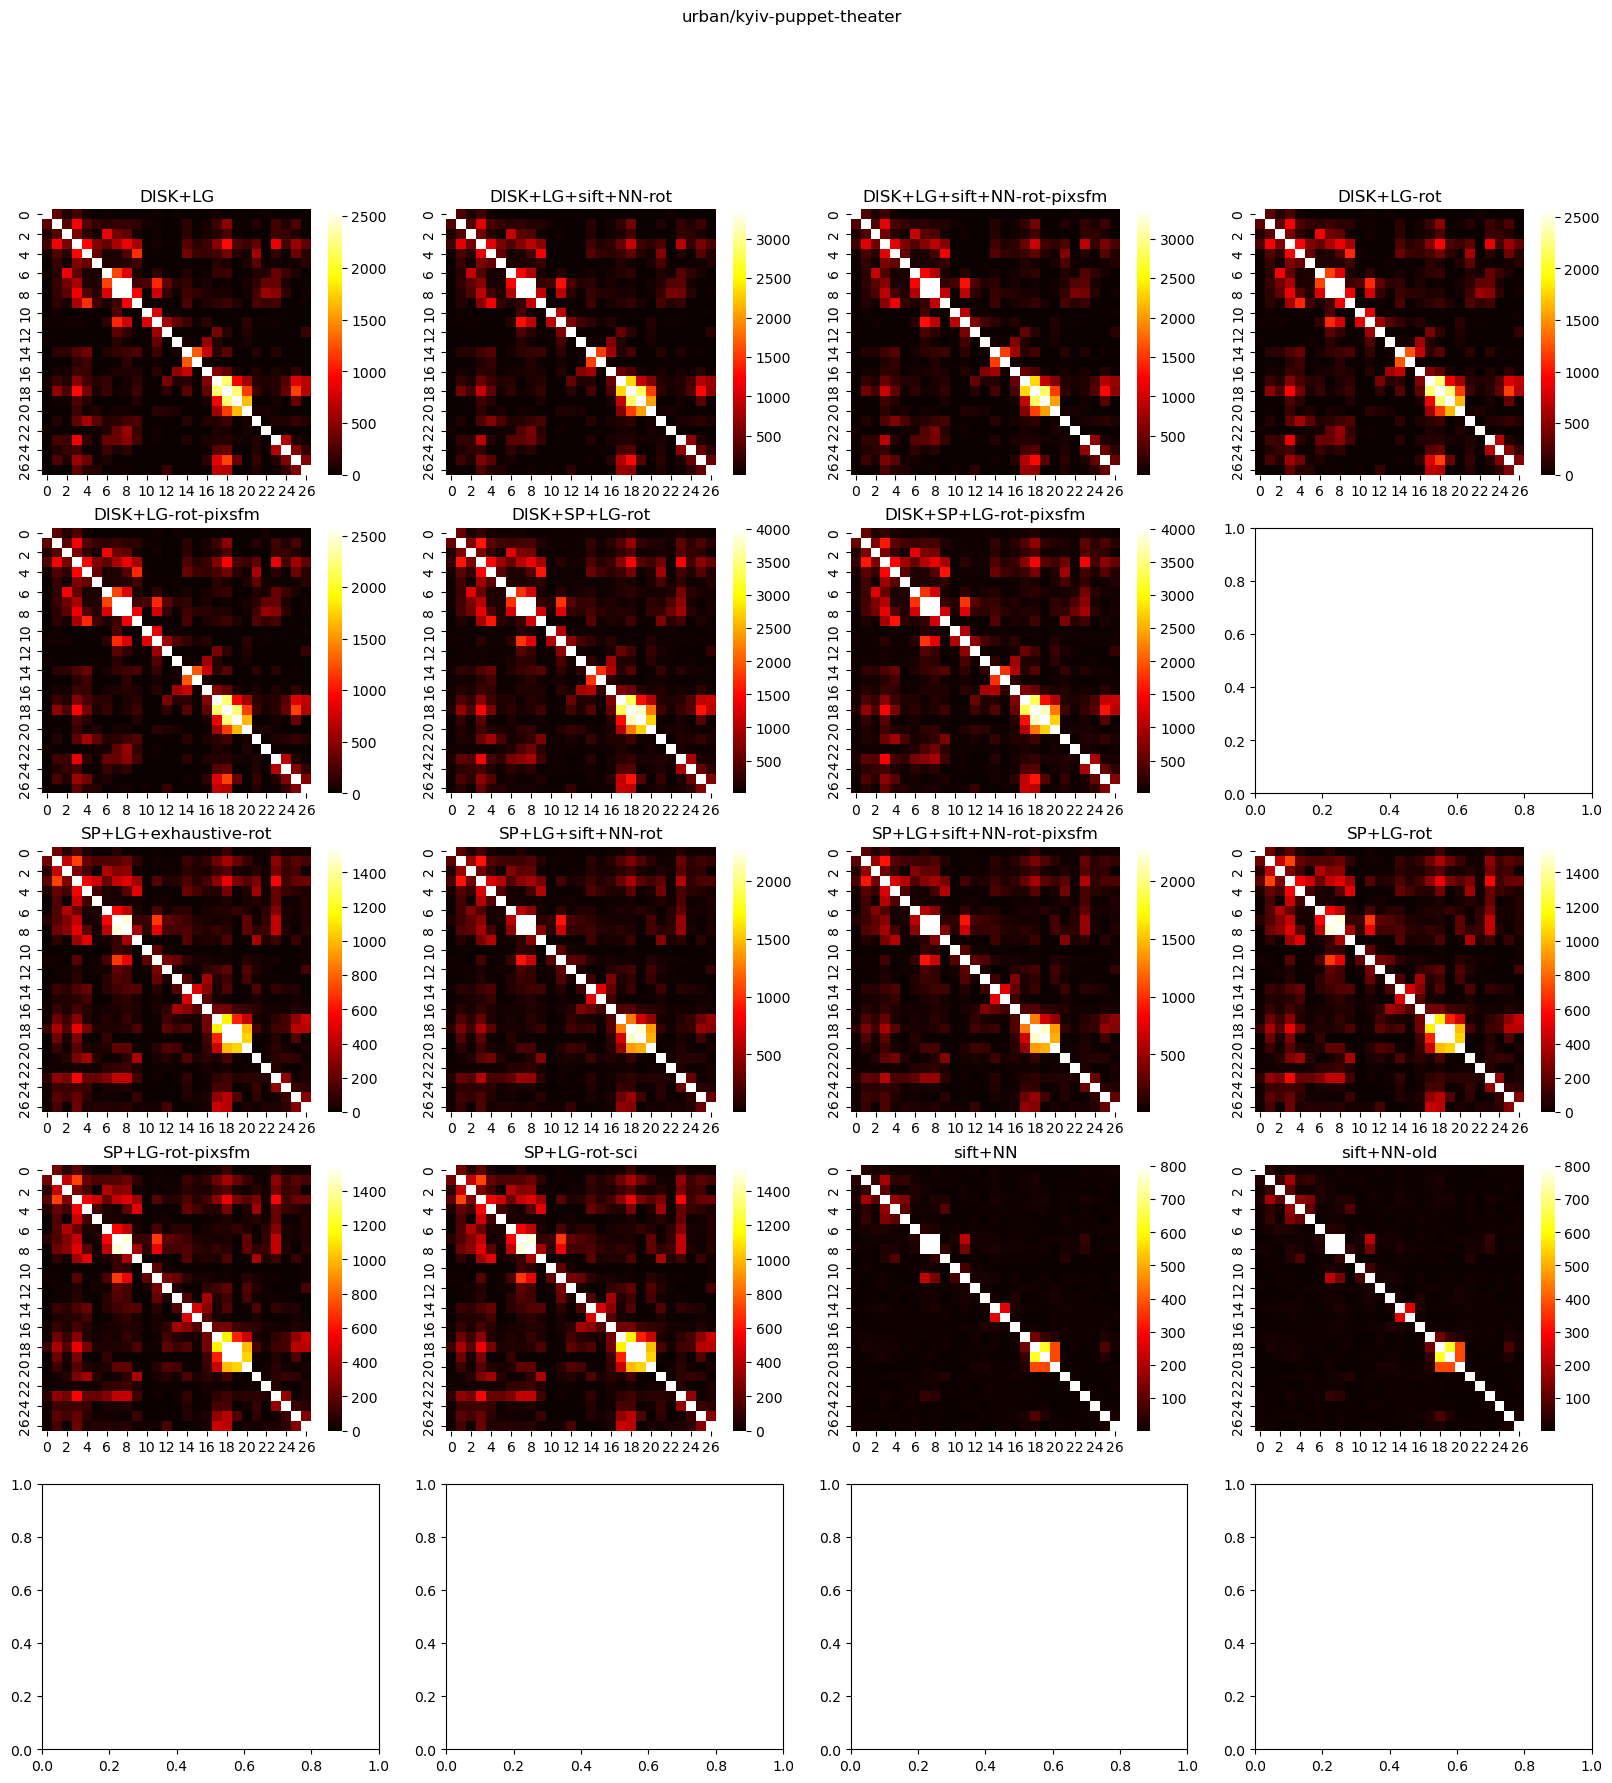

In [56]:

for ds in datasets.keys():
    for j, scene in enumerate(datasets[ds]):
        image_names = metrics[ds][scene]["images"]

        pbar = tqdm(runs, desc=f"{ds}/{scene}")

        rows = np.sqrt(len(runs))
        cols = np.ceil(len(runs) / rows)
        fig, ax = plt.subplots(int(rows+1), int(cols), figsize=(5 * cols, 5 * rows))

        for r_idx, r in enumerate(pbar):

            scene_dir = Path(f"{out_dir}/{r}/{ds}/{scene}")

            matches = scene_dir / "matches.h5"

            if not matches.exists():
                continue

            pairs = sorted(list_h5_names(matches))

            match_matrix = -np.ones([len(image_names), len(image_names)])
            for pair in pairs:
                name0, name1 = pair.split("/")
                idx0, idx1 = image_names.index(name0), image_names.index(name1)
                m, sc = get_matches(matches, name0, name1)
                match_matrix[idx0, idx1] = match_matrix[idx1, idx0] = m.shape[0]

            sns.heatmap(
                match_matrix,
                ax=ax[int(r_idx // cols), int(r_idx % cols)],
                cbar=True,
                cmap="hot",
                mask=match_matrix < 0,
            )

            ax[int(r_idx // cols), int(r_idx % cols)].set_title(r)

        plt.suptitle(f"{ds}/{scene}")
        plt.tight_layout()
        plt.show()


heritage/cyprus: 100%|██████████| 16/16 [00:05<00:00,  2.76it/s]


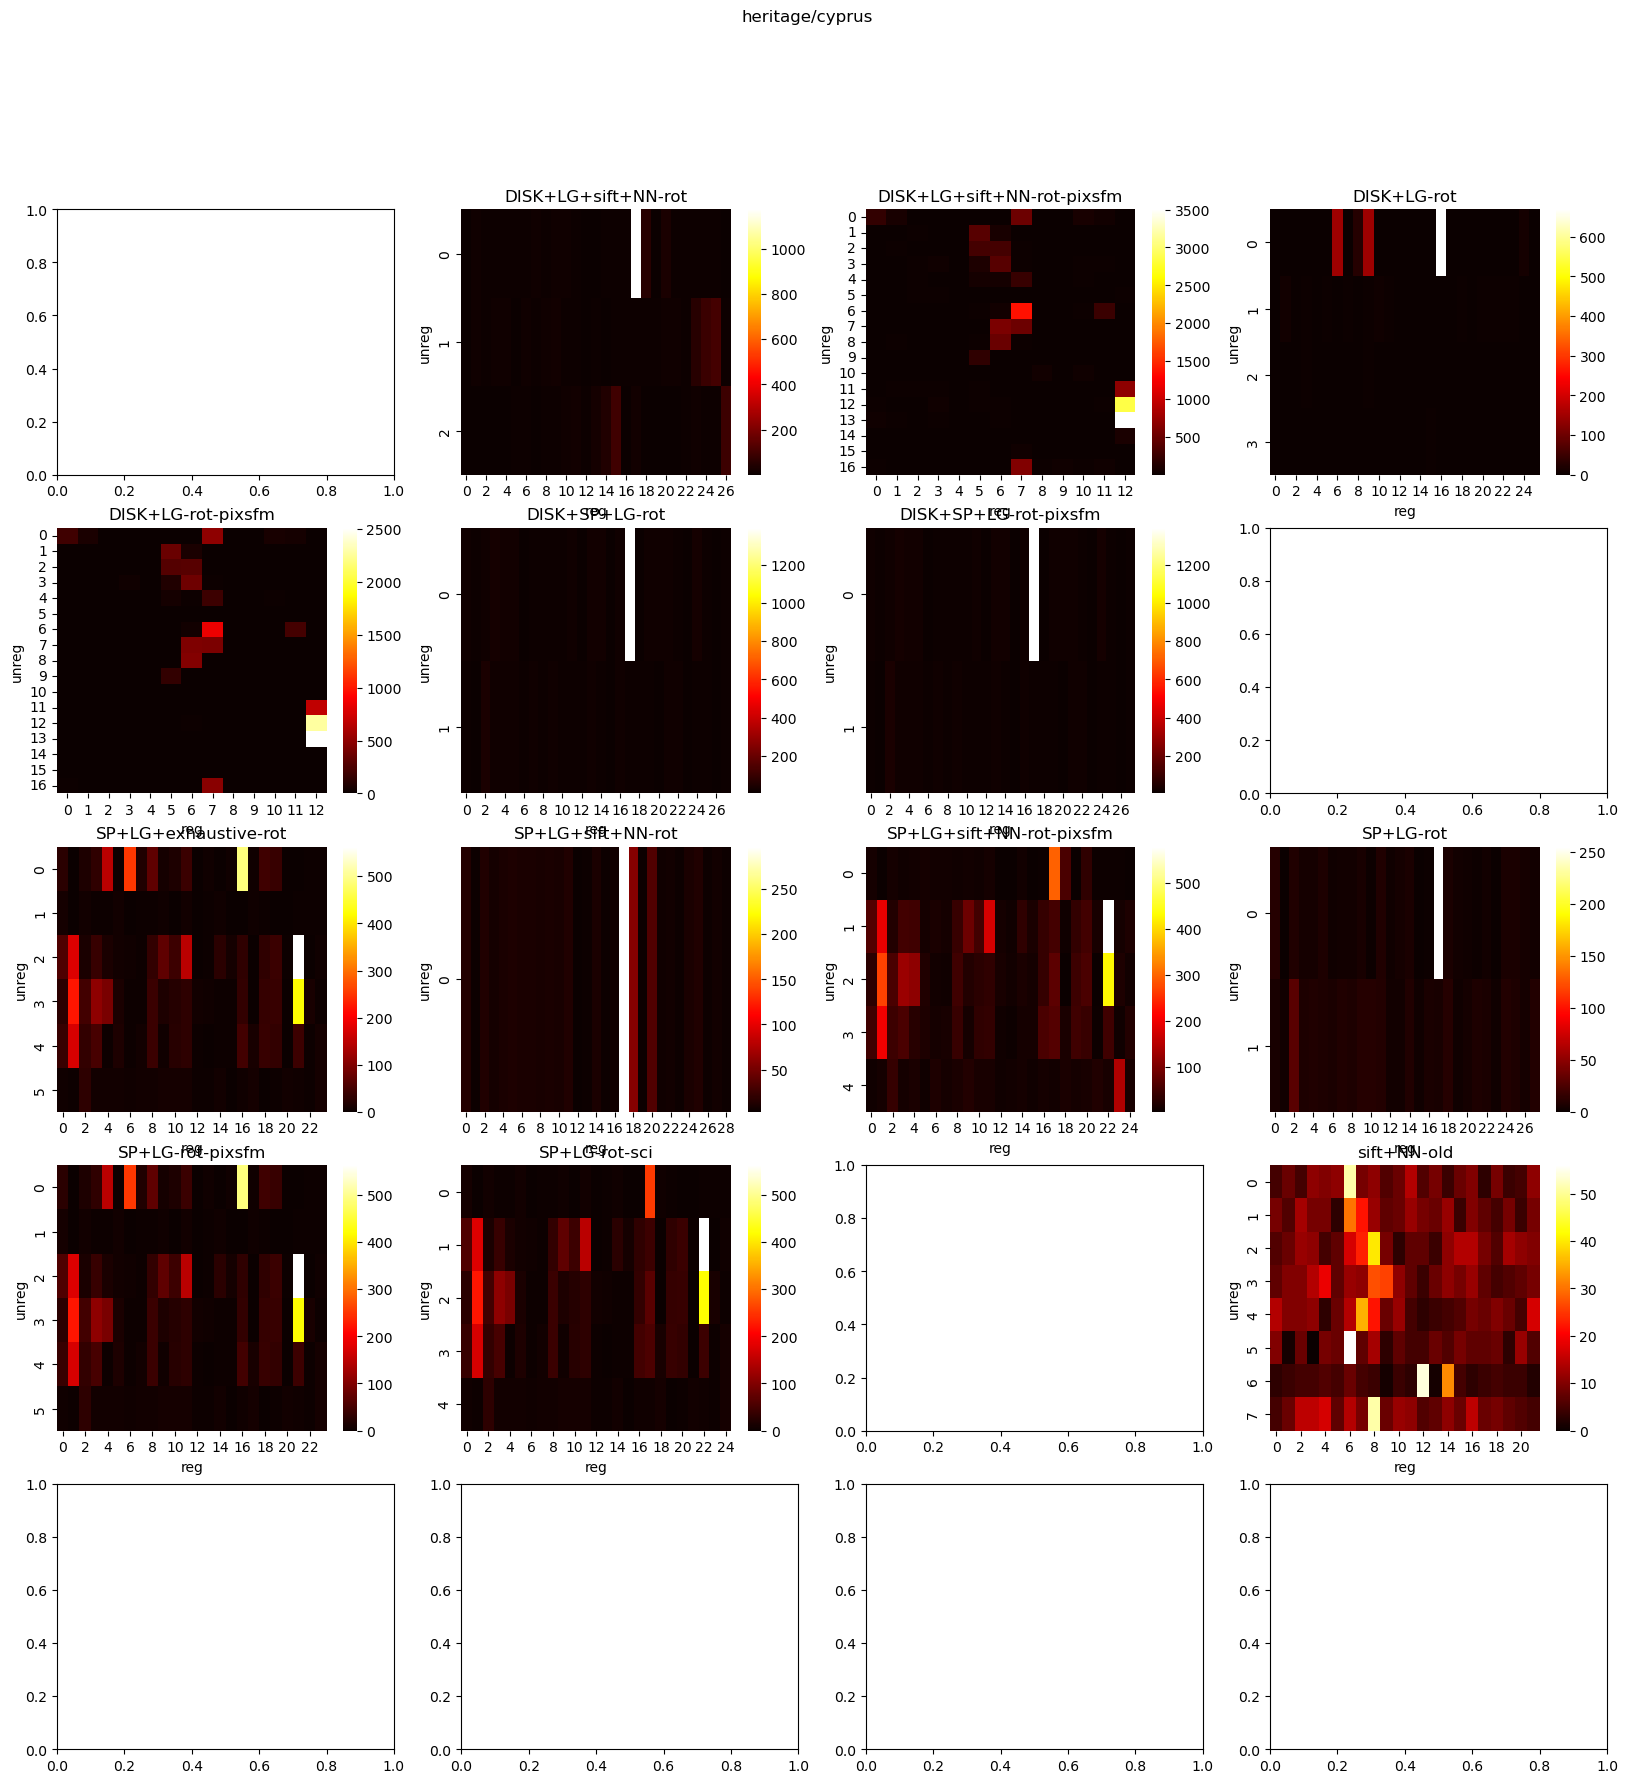

heritage/dioscuri: 100%|██████████| 16/16 [01:02<00:00,  3.90s/it]


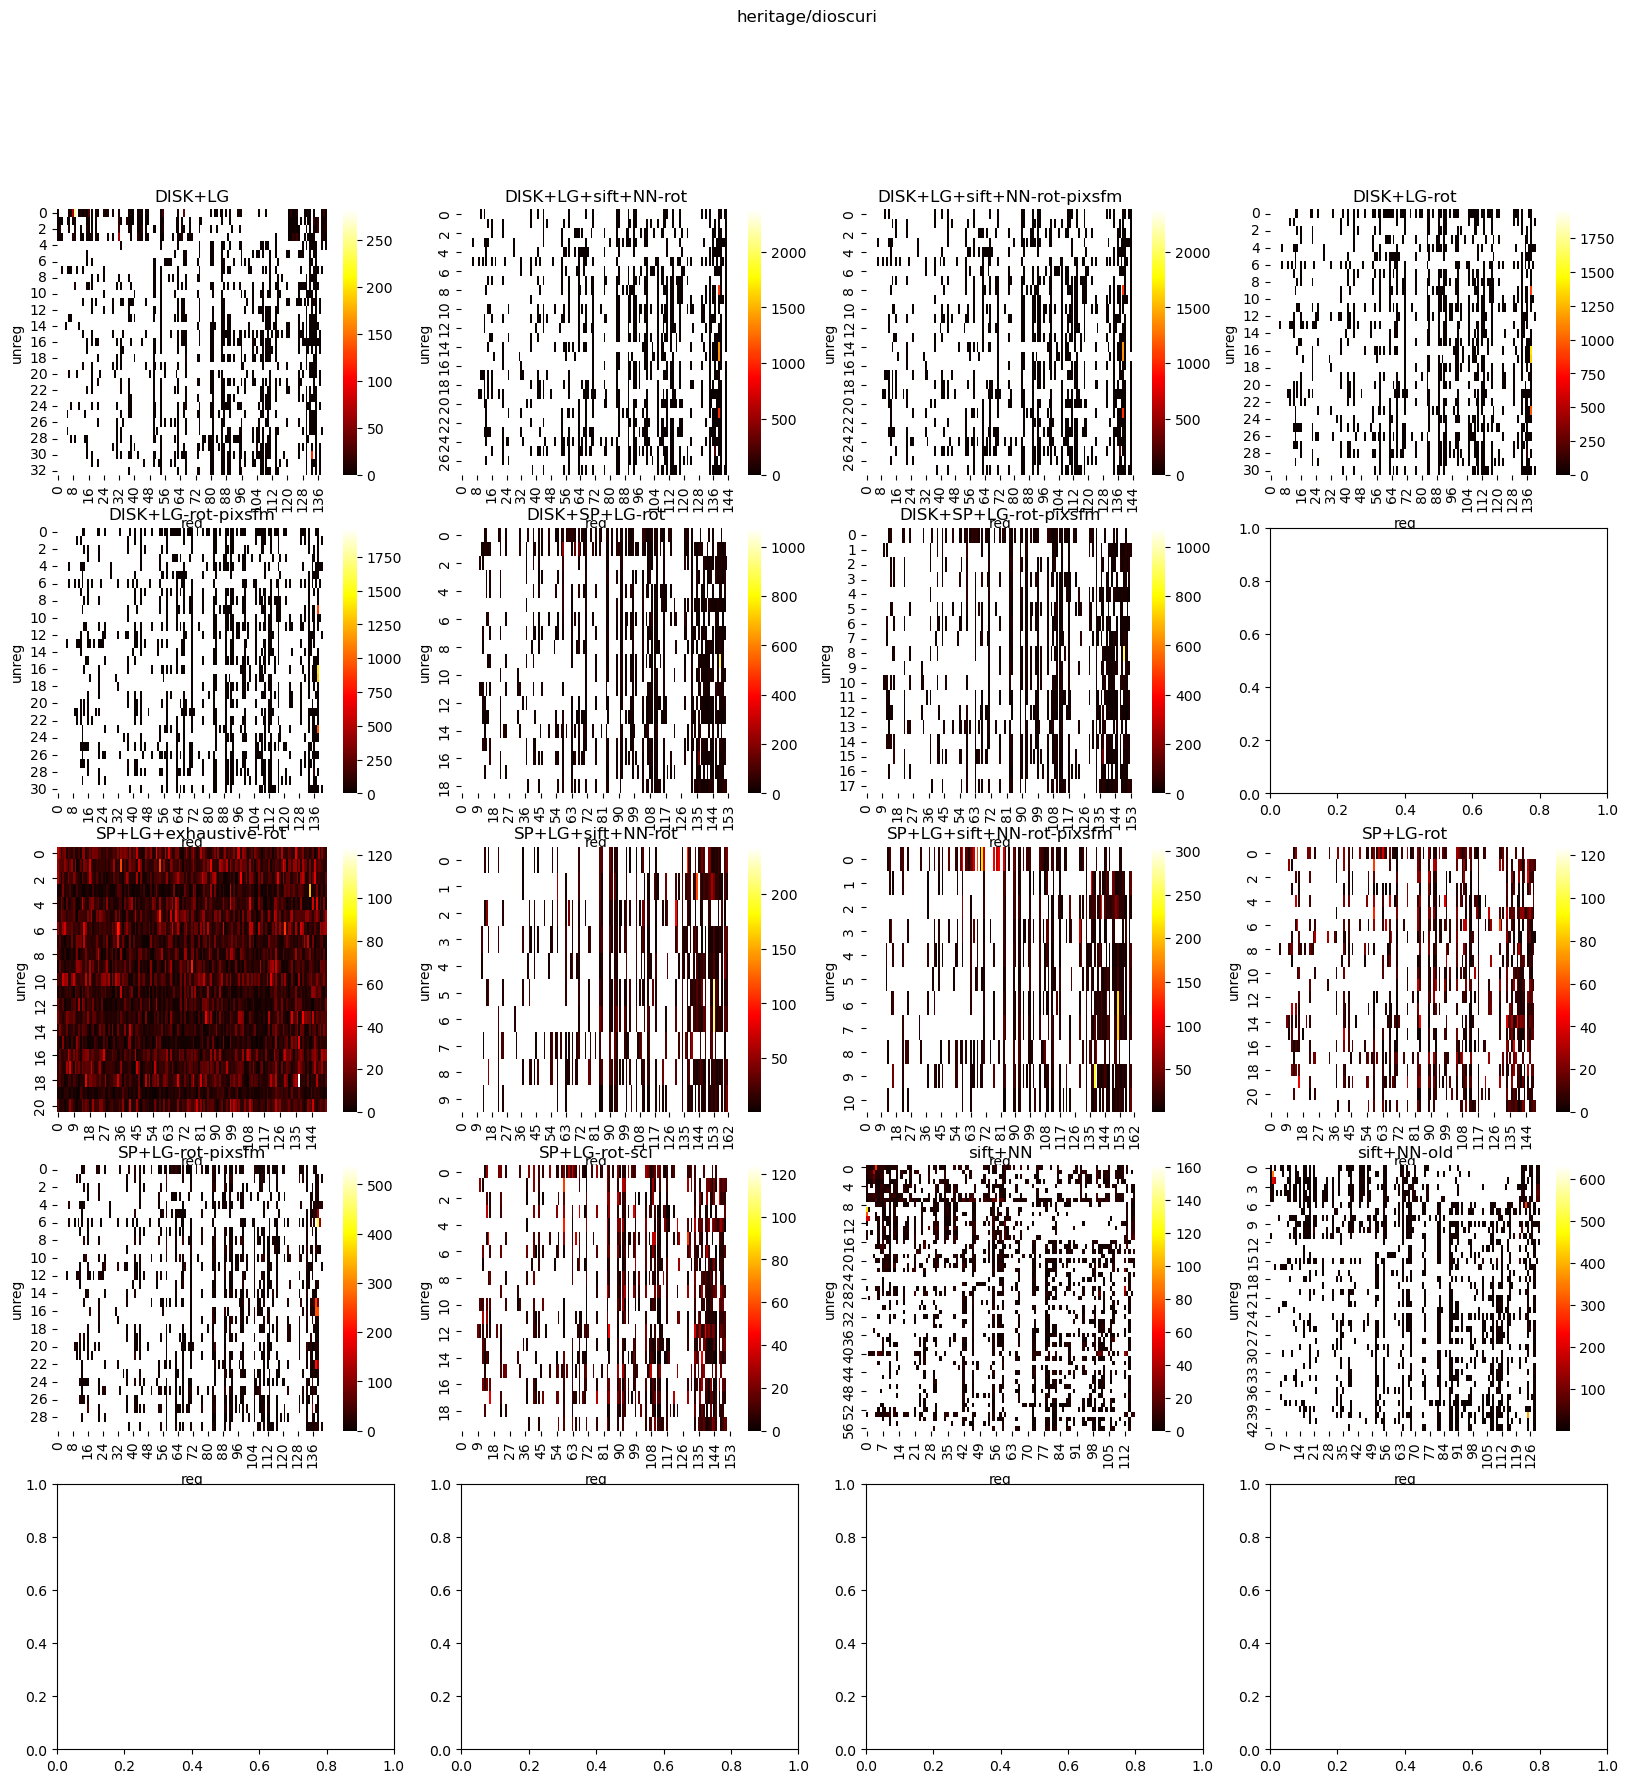

heritage/wall: 100%|██████████| 16/16 [00:00<00:00, 69.54it/s]


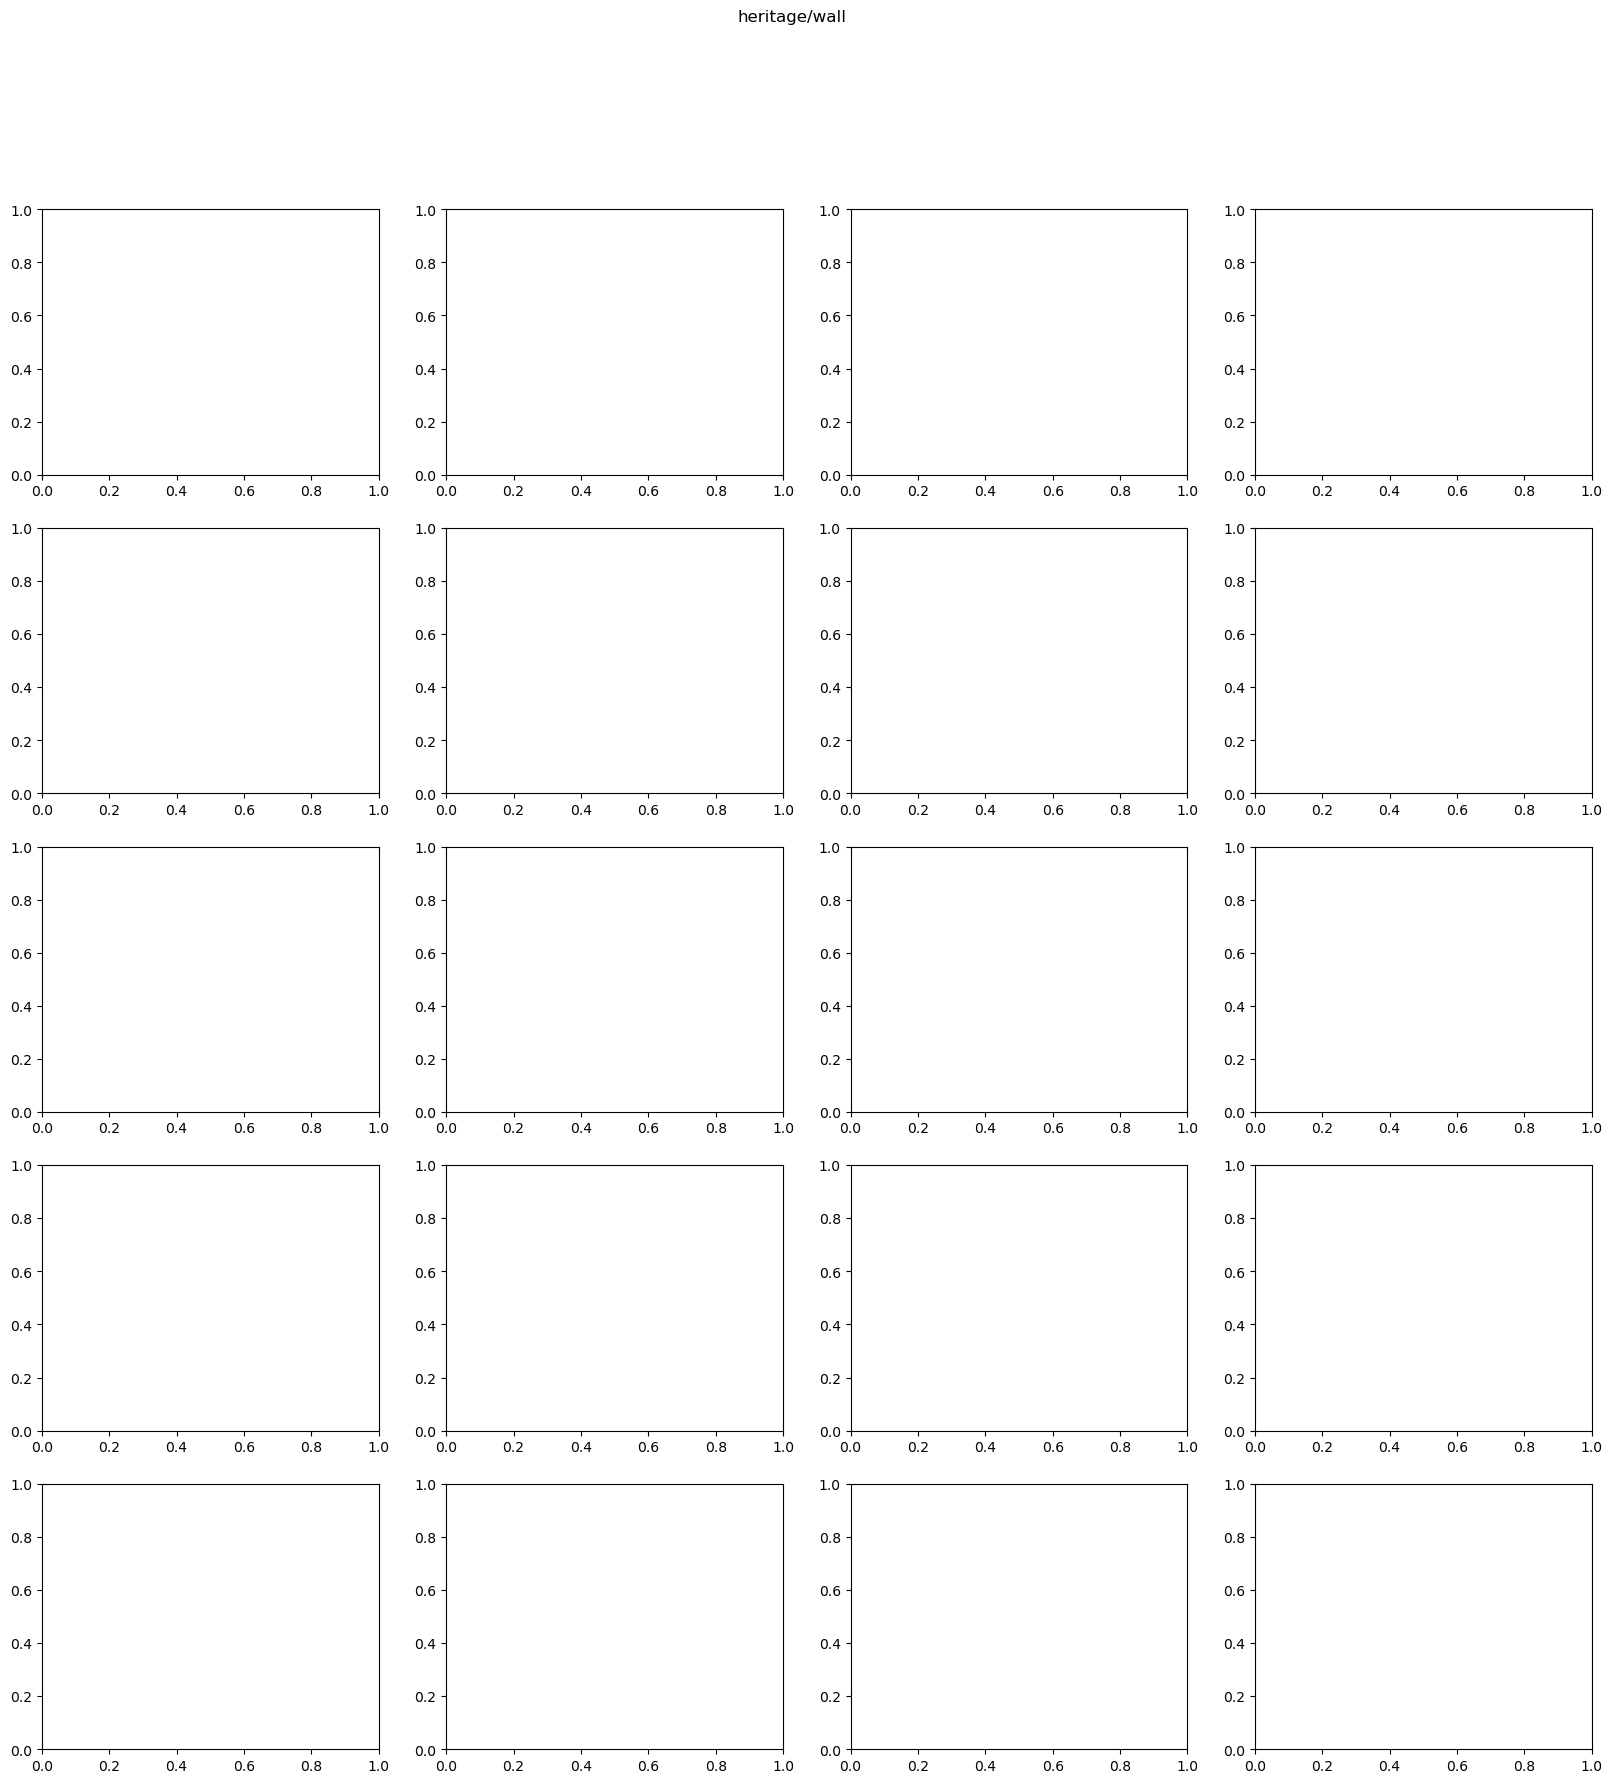

haiper/bike: 100%|██████████| 16/16 [00:00<00:00, 26.46it/s]


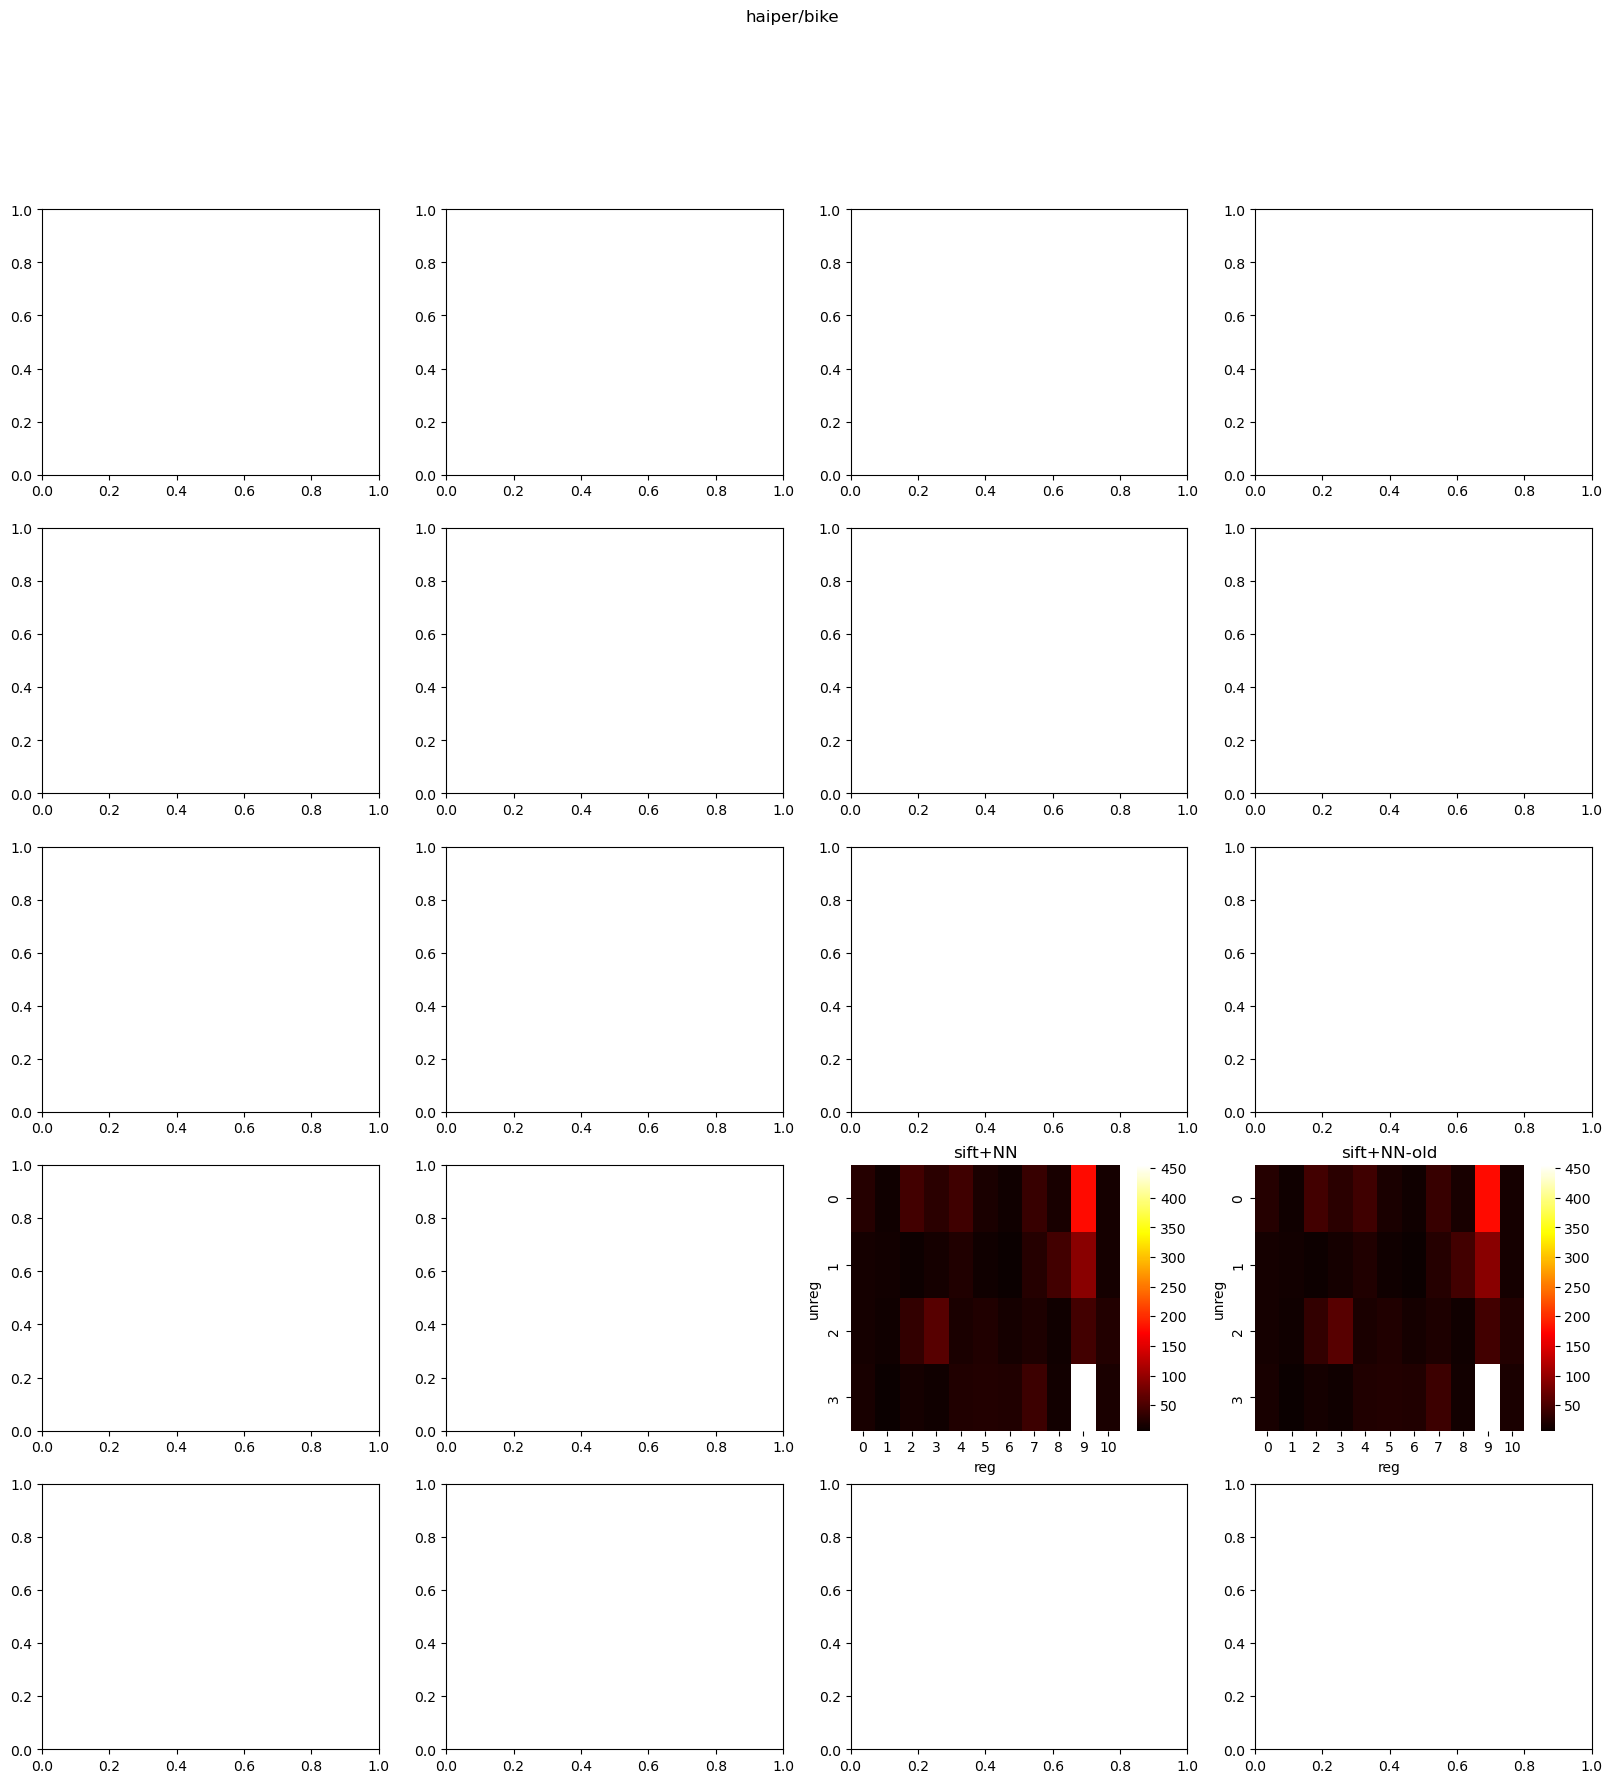

haiper/chairs: 100%|██████████| 16/16 [00:00<00:00, 145.61it/s]


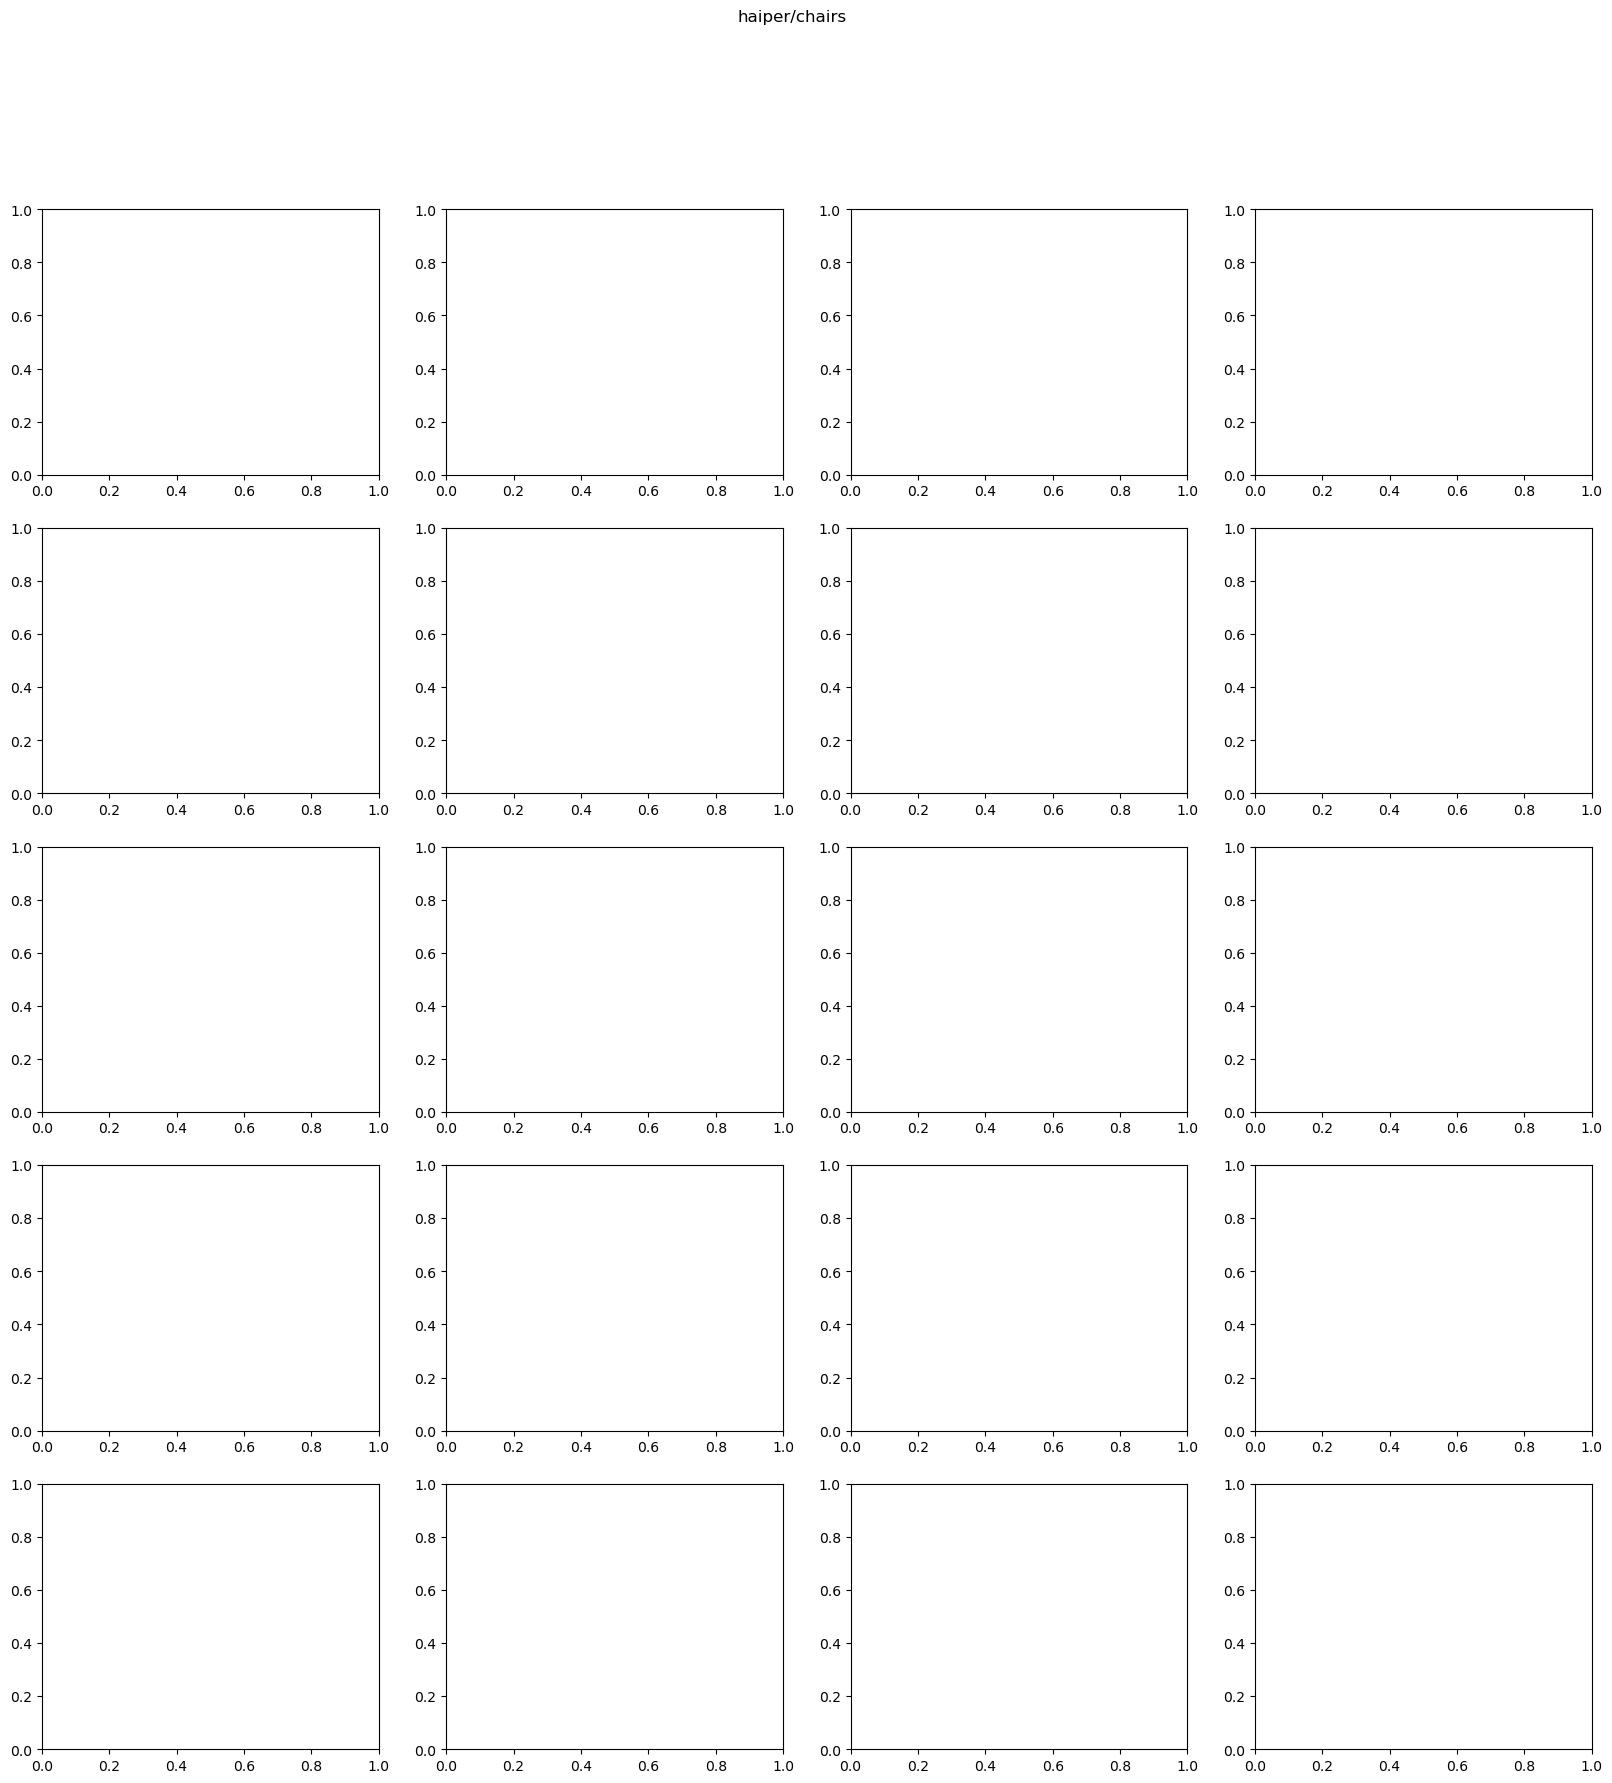

haiper/fountain: 100%|██████████| 16/16 [00:00<00:00, 52.61it/s]


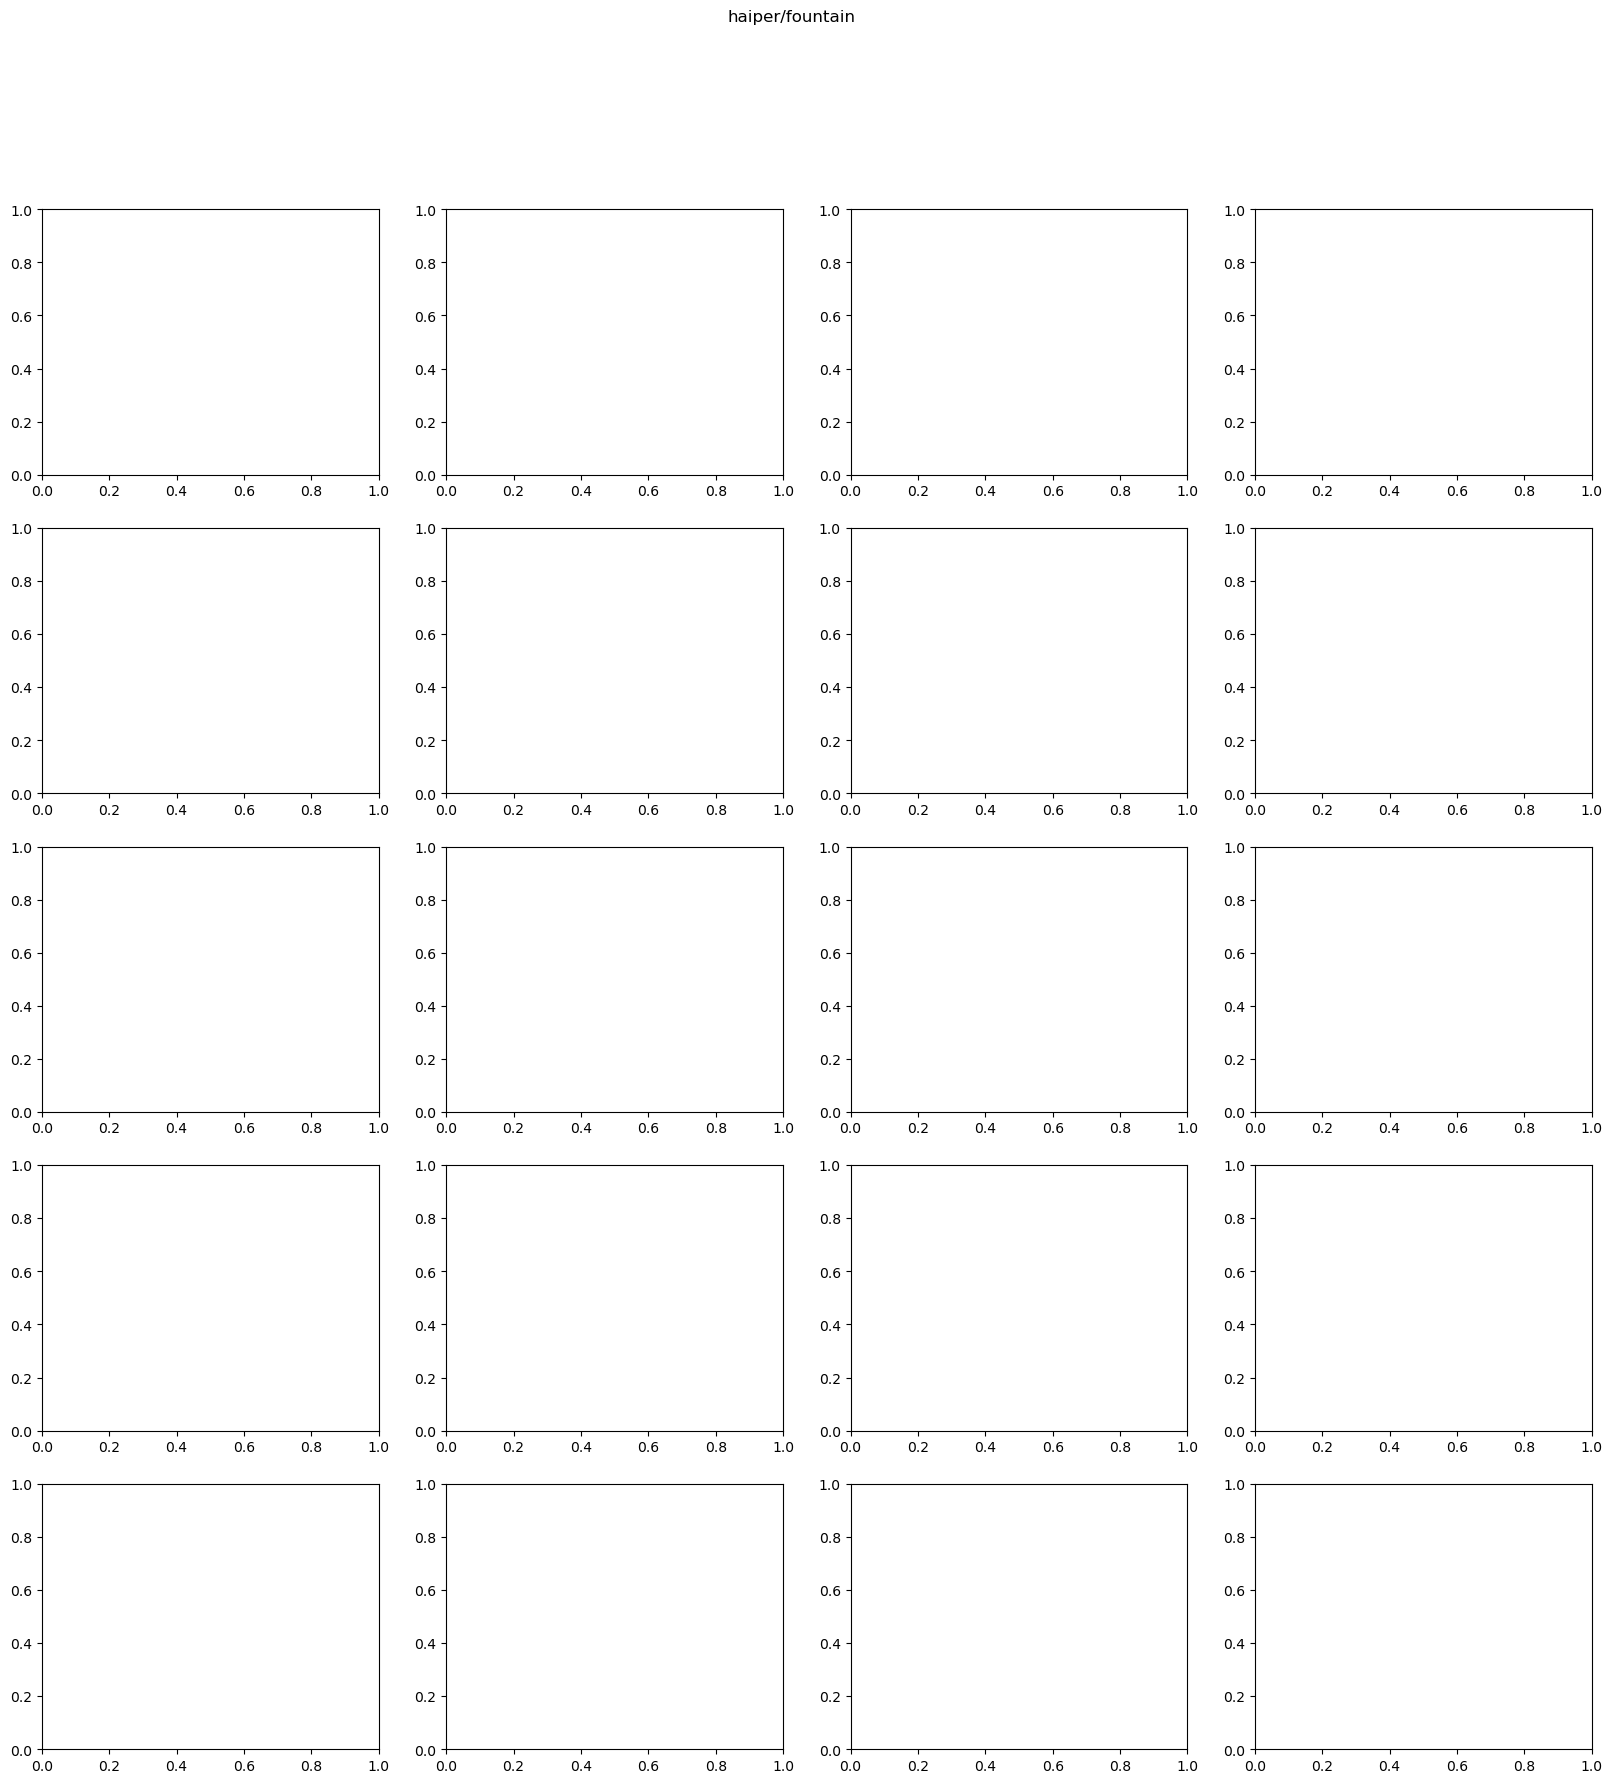

urban/kyiv-puppet-theater: 100%|██████████| 16/16 [00:00<00:00, 29.65it/s]


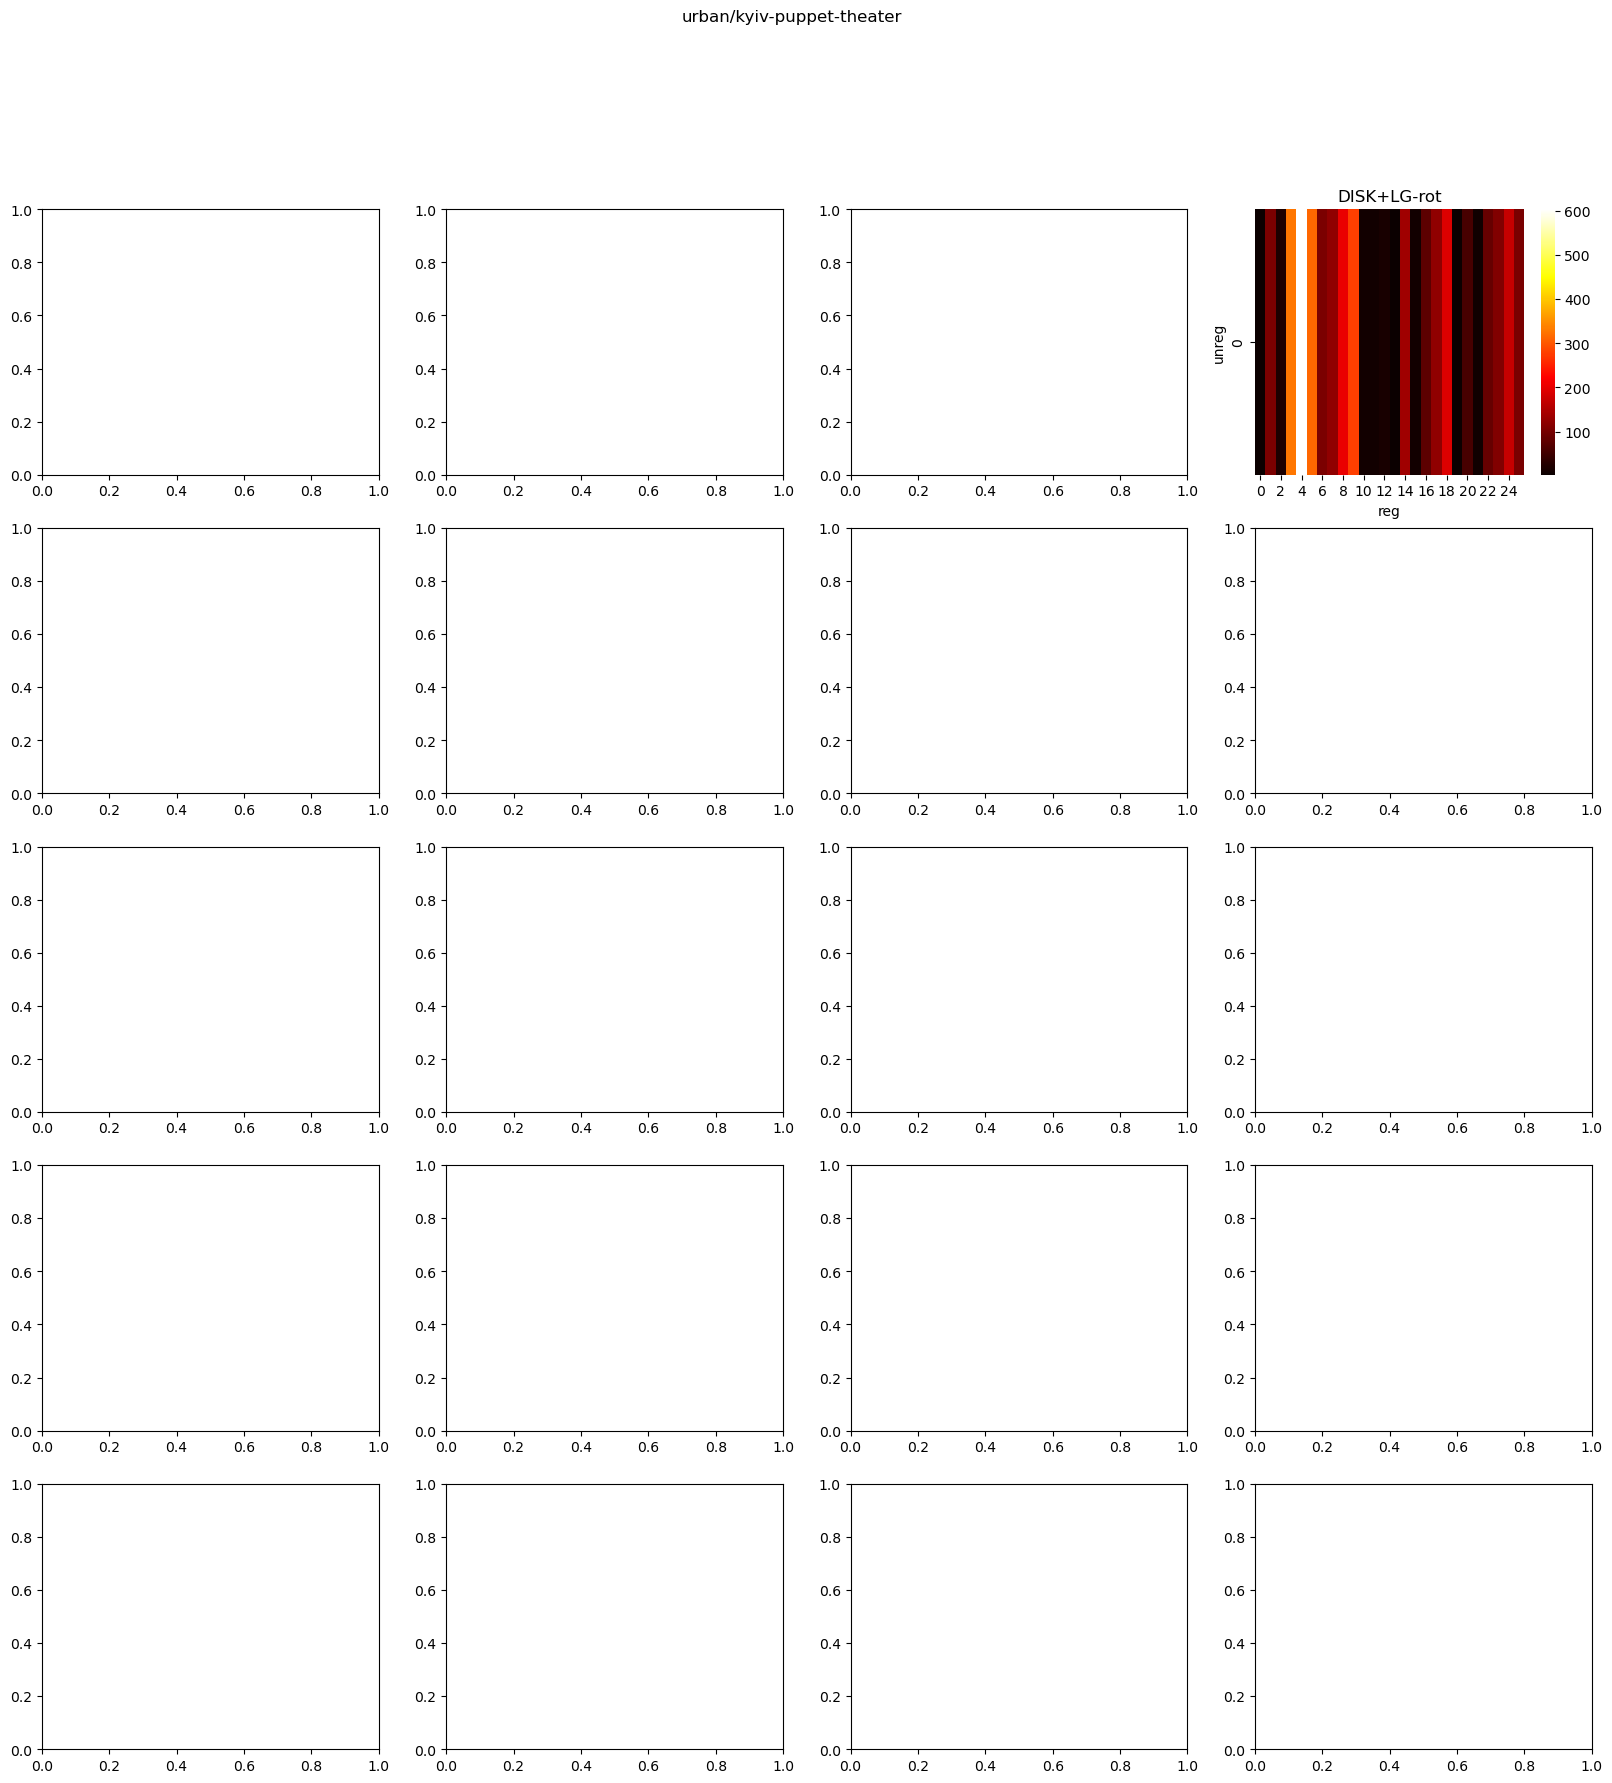

In [57]:

for ds in datasets.keys():
    for j, scene in enumerate(datasets[ds]):
        image_names = metrics[ds][scene]["images"]

        pbar = tqdm(runs, desc=f"{ds}/{scene}")

        rows = np.sqrt(len(runs))
        cols = np.ceil(len(runs) / rows)
        fig, ax = plt.subplots(int(rows+1), int(cols), figsize=(5 * cols, 5 * rows))

        for r_idx, r in enumerate(pbar):

            scene_dir = Path(f"{out_dir}/{r}/{ds}/{scene}")

            matches = scene_dir / "matches.h5"

            if not matches.exists():
                continue

            reg_images = metrics[ds][scene][r]["reg_images"]
            unreg_images = [img for img in image_names if img not in reg_images]

            if not unreg_images or len(reg_images) == 0:
                continue


            pairs = sorted(list_h5_names(matches))

            match_matrix = -np.ones([len(unreg_images), len(reg_images)])
            for pair in pairs:
                name0, name1 = pair.split("/")
                m, sc = get_matches(matches, name0, name1)

                if name0 in unreg_images and name1 in reg_images:
                    idx0, idx1 = unreg_images.index(name0), reg_images.index(name1)
                    match_matrix[idx0, idx1] = m.shape[0]

                elif name1 in unreg_images and name0 in reg_images:
                    idx0, idx1 = unreg_images.index(name1), reg_images.index(name0)
                    match_matrix[idx0, idx1] = m.shape[0]                

            sns.heatmap(
                match_matrix,
                ax=ax[int(r_idx // cols), int(r_idx % cols)],
                cbar=True,
                cmap="hot",
                mask=(match_matrix < 0),
            )

            ax[int(r_idx // cols), int(r_idx % cols)].set_title(r)
            ax[int(r_idx // cols), int(r_idx % cols)].set_xlabel("reg")
            ax[int(r_idx // cols), int(r_idx % cols)].set_ylabel("unreg")

        plt.suptitle(f"{ds}/{scene}")
        plt.tight_layout()
        plt.show()
